In [323]:
#download modis satelite image by date 
#python3.9 ./download_modis.py
from pyhdf.SD import SD, SDC
import numpy as np
import matplotlib.pyplot as plt
#from ipynb.fs.full.utils import *
import glob
from glob import glob
import os
import requests
from urllib.parse import urlparse
from bs4 import BeautifulSoup
import re
import csv
import h5py
import numpy as np
import json
import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from PIL import Image
import seaborn as sns
import matplotlib.colors as mcolors
#import pywt
diameter = 5

# NDVI: MOD13Q1

In [ ]:
----- MOD13Q1 : Vegetation Index hdf -----------
idx: 0     sds: 250m 16 days NDVI
idx: 1     sds: 250m 16 days EVI
idx: 2     sds: 250m 16 days VI Quality
idx: 3     sds: 250m 16 days red reflectance
idx: 4     sds: 250m 16 days NIR reflectance
idx: 5     sds: 250m 16 days blue reflectance
idx: 6     sds: 250m 16 days MIR reflectance
idx: 7     sds: 250m 16 days view zenith angle
idx: 8     sds: 250m 16 days sun zenith angle
idx: 9     sds: 250m 16 days relative azimuth angle
idx: 10     sds: 250m 16 days composite day of the year
idx: 11     sds: 250m 16 days pixel reliability
----- MOD11A2 : Land Surface Temperature (LST) and Emissivity hdf -----------
idx: 0     sds: LST_Day_1km
idx: 1     sds: QC_Day
idx: 2     sds: Day_view_time
idx: 3     sds: Day_view_angl
idx: 4     sds: LST_Night_1km
idx: 5     sds: QC_Night
idx: 6     sds: Night_view_time
idx: 7     sds: Night_view_angl
idx: 8     sds: Emis_31
idx: 9     sds: Emis_32
idx: 10     sds: Clear_sky_days
idx: 11     sds: Clear_sky_nights
----- MCD64A1 : burned area hdf -----------
idx: 0     sds: Burn Date
idx: 1     sds: Burn Date Uncertainty
idx: 2     sds: QA
idx: 3     sds: First Day
idx: 4     sds: Last Day
----- MOD14A2 : fire hdf -----------
idx: 0     sds: FireMask
idx: 1     sds: QA

In [324]:
def download_file(folder, filename, datestr, MOD_ID, urlprefix):
     
    username_file = open("/home/fun/profile/modis_username.txt", "r")
    password_file = open("/home/fun/profile/modis_password.txt", "r")
    username = username_file.readline()
    password = password_file.readline()
    
    url = generate_modis_url(datestr, MOD_ID, urlprefix)
    url = url + filename
    if len(filename) == 0:
        filename = 'fires_index_' + MOD_ID + '_' + datestr + '.html'
    
#     print ('downloading file ', url)
    
    r = requests.get(url, auth = (username, password))
    if r.status_code == 200:
        print ('writing to', folder + filename)
        with open(folder + filename, 'wb') as out:
            for bits in r.iter_content():
                out.write(bits)
#         print ('download error ', r.status_code)
        
def parse_html(html_file, MOD_ID):
    '''
    parse html to get file list
    '''

    with open(html_file, 'r') as input:
        soup = BeautifulSoup(input, "html.parser").find_all(lambda t: t.name == "a" and t.text.startswith(MOD_ID) and t.text.endswith('hdf'))
        filelist = []
        for it in soup:
            filelist.append(it["href"])
        return filelist

def generate_modis_url(datestr, MOD_ID , urlprefix):
    '''
    compose url using date  'YYYY.MM.DD'
    '''
    url = urlprefix + MOD_ID +'/'+ datestr[0:4] + '.' + datestr[5:7] + '.'+ datestr[8:10] + '/'
    
    return url

In [325]:
def download_one_fire(folder, MOD_ID, dt, urlprefix):
    download_html(folder, MOD_ID, dt, urlprefix)
    download_hdf(folder, MOD_ID, urlprefix)

def download_html(folder, MOD_ID, dt, urlprefix):
    profile = folder + 'profile.json'
    f = open(profile)
    info = json.load(f)
    
    if dt[-1] == 'd':
        start = datetime.datetime.strptime(info['start'], '%Y-%m-%d')
        end = datetime.datetime.strptime(info['end'], '%Y-%m-%d')
#         begin_date = start - timedelta(days= int(dt[0:len(dt)-1]))
#         final_date = end + timedelta(days= int(dt[0:len(dt)-1]))
        pre_fire_date = start - timedelta(days= 360)
        begin_date = end - timedelta(days= 16) # 
        final_date = end + timedelta(days= 16)
        post_fire_date = end + timedelta(days= 600)
        
        predatestr = pre_fire_date.strftime('%Y-%m-%d')
        print(predatestr)
        url = generate_modis_url(predatestr, MOD_ID, urlprefix)
        download_file(folder, "", predatestr, MOD_ID, urlprefix)
        
        postdatestr = post_fire_date.strftime('%Y-%m-%d')
        print(post_fire_date)
        url = generate_modis_url(post_fire_date, MOD_ID, urlprefix)
        download_file(folder, "", post_fire_date, MOD_ID, urlprefix)
            
        it_date = begin_date 
        while (it_date < final_date):
            datestr = it_date.strftime('%Y-%m-%d')
            print(datestr)
            url = generate_modis_url(datestr, MOD_ID, urlprefix)
            download_file(folder, "", datestr, MOD_ID, urlprefix)

            if os.path.isfile(folder + 'fires_index_' + MOD_ID + '_' +datestr + '.html'):
                it_date = it_date + timedelta(days= 16)
            else:
                it_date = it_date + timedelta(days=1)
                
    elif dt[-1] == 'm':
        start = datetime.datetime.strptime(info['start'][0:7]+'-01', '%Y-%m-%d')
        end = datetime.datetime.strptime(info['end'][0:7]+'-01', '%Y-%m-%d')
        
        #begin_date = start - relativedelta(months = 1) 
        begin_date = start  # TODO: if fire starts on 1st day of month, need to addjust month
        final_date = end + relativedelta(months=1)

        it_date = begin_date
        while (it_date <= final_date):
            datestr = it_date.strftime('%Y-%m-%d')
            print(datestr)
            url = generate_modis_url(datestr, MOD_ID, urlprefix)
            print(url)
            download_file(folder, "", datestr, MOD_ID, urlprefix)
            
            it_date = it_date + relativedelta(months=1)
        
def download_hdf(folder, MOD_ID, urlprefix):
    globdirc = folder + '*.html'
    for filename in glob(globdirc):
        datestr = filename[-15:-5]
        print ('parsing %s' % filename)
        filelist = parse_html(filename, MOD_ID.split(".")[0])
        for hdf in filelist:
            if ('h08v04' in hdf) or ('h08v05' in hdf):
                print('downloading ', hdf, 'to ', folder)
                download_file(folder, hdf, datestr, MOD_ID, urlprefix)

================= downloading  /home/fun/wildfire_data/Route_Fire_2022-08-31==================
2022-07-02
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2022.07.02/
download error  404
2022-07-03
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2022.07.03/
download error  404
2022-07-04
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2022.07.04/
download error  404
2022-07-05
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2022.07.05/
download error  404
2022-07-06
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2022.07.06/
download error  404
2022-07-07
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2022.07.07/
download error  404
2022-07-08
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2022.07.08/
download error  404
2022-07-09
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2022.07.09/
download error  404
2022-07-10
downloading file  https://e4ftl01.cr.usgs.gov/

download error  404
2023-03-23
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.03.23/
download error  404
2023-03-24
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.03.24/
download error  404
2023-03-25
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.03.25/
download error  404
2023-03-26
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.03.26/
download error  404
2023-03-27
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.03.27/
download error  404
2023-03-28
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.03.28/
download error  404
2023-03-29
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.03.29/
download error  404
2023-03-30
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.03.30/
download error  404
2023-03-31
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.03.31/
download error  404
2023-04-01
downloading fil

download error  404
2023-06-10
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.06.10/
download error  404
2023-06-11
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.06.11/
download error  404
2023-06-12
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.06.12/
download error  404
2023-06-13
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.06.13/
download error  404
2023-06-14
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.06.14/
download error  404
2023-06-15
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.06.15/
download error  404
2023-06-16
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.06.16/
download error  404
2023-06-17
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.06.17/
download error  404
2023-06-18
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.06.18/
download error  404
2023-06-19
downloading fil

download error  404
2023-08-27
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.08.27/
download error  404
2023-08-28
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.08.28/
download error  404
2023-08-29
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.08.29/
download error  404
2023-08-30
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.08.30/
download error  404
2023-08-31
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.08.31/
download error  404
2023-09-01
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.09.01/
download error  404
2023-09-02
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.09.02/
download error  404
2023-09-03
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.09.03/
download error  404
2023-09-04
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2023.09.04/
download error  404
2023-09-05
downloading fil

parsing /home/fun/wildfire_data/Route_Fire_2022-08-31/fires_index_MOD14A2.006_2022-10-16.html
parsing /home/fun/wildfire_data/Route_Fire_2022-08-31/fires_index_MOD14A2.006_2022-11-01.html
parsing /home/fun/wildfire_data/Route_Fire_2022-08-31/fires_index_MOD14A2.006_2022-11-17.html
parsing /home/fun/wildfire_data/Route_Fire_2022-08-31/fires_index_MOD14A2.006_2022-12-03.html
parsing /home/fun/wildfire_data/Route_Fire_2022-08-31/fires_index_MOD14A2.006_2022-12-19.html
parsing /home/fun/wildfire_data/Route_Fire_2022-08-31/fires_index_MOD14A2.006_2023-01-09.html
parsing /home/fun/wildfire_data/Route_Fire_2022-08-31/fires_index_MOD14A2.006_2023-01-25.html
parsing /home/fun/wildfire_data/Route_Fire_2022-08-31/fires_index_MOD14A2.006_2023-02-10.html
parsing /home/fun/wildfire_data/Route_Fire_2022-08-31/fires_index_MOD13Q1.006_2022-08-29.html
downloading  MOD13Q1.A2022241.h08v04.006.2022258224810.hdf to  /home/fun/wildfire_data/Route_Fire_2022-08-31/
downloading file  https://e4ftl01.cr.usgs.go

writing to /home/fun/wildfire_data/Route_Fire_2022-08-31/MOD13Q1.A2023033.h08v05.006.2023050041935.hdf
parsing /home/fun/wildfire_data/Route_Fire_2022-08-31/fires_index_MOD11A2.006_2022-08-29.html
parsing /home/fun/wildfire_data/Route_Fire_2022-08-31/fires_index_MOD11A2.006_2022-09-14.html
parsing /home/fun/wildfire_data/Route_Fire_2022-08-31/fires_index_MOD11A2.006_2022-09-30.html
parsing /home/fun/wildfire_data/Route_Fire_2022-08-31/fires_index_MOD11A2.006_2022-10-16.html
parsing /home/fun/wildfire_data/Route_Fire_2022-08-31/fires_index_MOD11A2.006_2022-11-01.html
parsing /home/fun/wildfire_data/Route_Fire_2022-08-31/fires_index_MCD64A1.006_2022-08-01.html
parsing /home/fun/wildfire_data/Route_Fire_2022-08-31/fires_index_MCD64A1.006_2022-09-01.html
parsing /home/fun/wildfire_data/Route_Fire_2022-08-31/fires_index_MCD64A1.006_2022-10-01.html
parsing /home/fun/wildfire_data/Route_Fire_2022-08-31/fires_index_MCD64A1.006_2022-11-01.html
parsing /home/fun/wildfire_data/Route_Fire_2022-08-

download error  404
2022-12-24
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2022.12.24/
download error  404
2022-12-25
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2022.12.25/
download error  404
2022-12-26
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2022.12.26/
download error  404
2022-12-27
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2022.12.27/
download error  404
2022-12-28
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2022.12.28/
download error  404
2022-12-29
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2022.12.29/
download error  404
2022-12-30
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2022.12.30/
download error  404
2022-12-31
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2022.12.31/
download error  404
2023-01-01
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.01.01/
download error  404
2023-01-02
downloading fil

download error  404
2023-03-12
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.03.12/
download error  404
2023-03-13
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.03.13/
download error  404
2023-03-14
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.03.14/
download error  404
2023-03-15
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.03.15/
download error  404
2023-03-16
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.03.16/
download error  404
2023-03-17
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.03.17/
download error  404
2023-03-18
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.03.18/
download error  404
2023-03-19
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.03.19/
download error  404
2023-03-20
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.03.20/
download error  404
2023-03-21
downloading fil

download error  404
2023-05-29
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.05.29/
download error  404
2023-05-30
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.05.30/
download error  404
2023-05-31
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.05.31/
download error  404
2023-06-01
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.06.01/
download error  404
2023-06-02
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.06.02/
download error  404
2023-06-03
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.06.03/
download error  404
2023-06-04
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.06.04/
download error  404
2023-06-05
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.06.05/
download error  404
2023-06-06
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.06.06/
download error  404
2023-06-07
downloading fil

download error  404
2023-08-15
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.08.15/
download error  404
2023-08-16
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.08.16/
download error  404
2023-08-17
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.08.17/
download error  404
2023-08-18
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.08.18/
download error  404
2023-08-19
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.08.19/
download error  404
2023-08-20
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.08.20/
download error  404
2023-08-21
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.08.21/
download error  404
2023-08-22
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.08.22/
download error  404
2023-08-23
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.08.23/
download error  404
2023-08-24
downloading fil

download error  404
2023-11-01
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.11.01/
download error  404
2023-11-02
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.11.02/
download error  404
2023-11-03
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.11.03/
download error  404
2023-11-04
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.11.04/
download error  404
2023-11-05
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.11.05/
download error  404
2023-11-06
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.11.06/
download error  404
2023-11-07
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.11.07/
download error  404
2023-11-08
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.11.08/
download error  404
2023-11-09
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2023.11.09/
download error  404
2023-11-10
downloading fil

writing to /home/fun/wildfire_data/Route_Fire_2022-08-31/MOD11A2.A2022201.h08v05.006.2022215024256.hdf
parsing /home/fun/wildfire_data/Route_Fire_2022-08-31/fires_index_MOD11A2.006_2022-08-05.html
downloading  MOD11A2.A2022217.h08v04.006.2022232023149.hdf to  /home/fun/wildfire_data/Route_Fire_2022-08-31/
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2022.08.05/MOD11A2.A2022217.h08v04.006.2022232023149.hdf
writing to /home/fun/wildfire_data/Route_Fire_2022-08-31/MOD11A2.A2022217.h08v04.006.2022232023149.hdf
downloading  MOD11A2.A2022217.h08v05.006.2022232023049.hdf to  /home/fun/wildfire_data/Route_Fire_2022-08-31/
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2022.08.05/MOD11A2.A2022217.h08v05.006.2022232023049.hdf
writing to /home/fun/wildfire_data/Route_Fire_2022-08-31/MOD11A2.A2022217.h08v05.006.2022232023049.hdf
parsing /home/fun/wildfire_data/Route_Fire_2022-08-31/fires_index_MOD11A2.006_2022-08-21.html
downloading  MOD11A2.A2022233.h08v04.006.20

download error  404
2023-01-17
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.01.17/
writing to /home/fun/wildfire_data/Route_Fire_2022-08-31/fires_index_MOD14A2.006_2023-01-17.html
2023-02-02
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.02.02/
writing to /home/fun/wildfire_data/Route_Fire_2022-08-31/fires_index_MOD14A2.006_2023-02-02.html
2023-02-18
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.02.18/
download error  404
2023-02-19
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.02.19/
download error  404
2023-02-20
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.02.20/
download error  404
2023-02-21
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.02.21/
download error  404
2023-02-22
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.02.22/
download error  404
2023-02-23
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.02.23

download error  404
2023-05-04
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.05.04/
download error  404
2023-05-05
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.05.05/
download error  404
2023-05-06
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.05.06/
download error  404
2023-05-07
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.05.07/
download error  404
2023-05-08
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.05.08/
download error  404
2023-05-09
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.05.09/
download error  404
2023-05-10
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.05.10/
download error  404
2023-05-11
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.05.11/
download error  404
2023-05-12
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.05.12/
download error  404
2023-05-13
downloading fil

download error  404
2023-07-21
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.07.21/
download error  404
2023-07-22
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.07.22/
download error  404
2023-07-23
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.07.23/
download error  404
2023-07-24
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.07.24/
download error  404
2023-07-25
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.07.25/
download error  404
2023-07-26
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.07.26/
download error  404
2023-07-27
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.07.27/
download error  404
2023-07-28
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.07.28/
download error  404
2023-07-29
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.07.29/
download error  404
2023-07-30
downloading fil

download error  404
2023-10-07
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.10.07/
download error  404
2023-10-08
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.10.08/
download error  404
2023-10-09
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.10.09/
download error  404
2023-10-10
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.10.10/
download error  404
2023-10-11
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.10.11/
download error  404
2023-10-12
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.10.12/
download error  404
2023-10-13
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.10.13/
download error  404
2023-10-14
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.10.14/
download error  404
2023-10-15
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2023.10.15/
download error  404
2023-10-16
downloading fil

writing to /home/fun/wildfire_data/Route_Fire_2022-08-31/MOD14A2.A2022337.h08v05.006.2022357182053.hdf
parsing /home/fun/wildfire_data/Route_Fire_2022-08-31/fires_index_MOD14A2.006_2022-12-19.html
downloading  MOD14A2.A2022353.h08v04.006.2022362121602.hdf to  /home/fun/wildfire_data/Route_Fire_2022-08-31/
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2022.12.19/MOD14A2.A2022353.h08v04.006.2022362121602.hdf
writing to /home/fun/wildfire_data/Route_Fire_2022-08-31/MOD14A2.A2022353.h08v04.006.2022362121602.hdf
downloading  MOD14A2.A2022353.h08v05.006.2022362121242.hdf to  /home/fun/wildfire_data/Route_Fire_2022-08-31/
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2022.12.19/MOD14A2.A2022353.h08v05.006.2022362121242.hdf
writing to /home/fun/wildfire_data/Route_Fire_2022-08-31/MOD14A2.A2022353.h08v05.006.2022362121242.hdf
parsing /home/fun/wildfire_data/Route_Fire_2022-08-31/fires_index_MOD14A2.006_2023-01-09.html
downloading  MOD14A2.A2023009.h08v04.006.20

writing to /home/fun/wildfire_data/Route_Fire_2022-08-31/MOD14A2.A2022217.h08v05.006.2022231223004.hdf
parsing /home/fun/wildfire_data/Route_Fire_2022-08-31/fires_index_MOD14A2.006_2022-08-21.html
downloading  MOD14A2.A2022233.h08v04.006.2022241231316.hdf to  /home/fun/wildfire_data/Route_Fire_2022-08-31/
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2022.08.21/MOD14A2.A2022233.h08v04.006.2022241231316.hdf
writing to /home/fun/wildfire_data/Route_Fire_2022-08-31/MOD14A2.A2022233.h08v04.006.2022241231316.hdf
downloading  MOD14A2.A2022233.h08v05.006.2022241231031.hdf to  /home/fun/wildfire_data/Route_Fire_2022-08-31/
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2022.08.21/MOD14A2.A2022233.h08v05.006.2022241231031.hdf
writing to /home/fun/wildfire_data/Route_Fire_2022-08-31/MOD14A2.A2022233.h08v05.006.2022241231031.hdf
parsing /home/fun/wildfire_data/Route_Fire_2022-08-31/fires_index_MOD14A2.006_2022-09-06.html
downloading  MOD14A2.A2022249.h08v04.006.20

writing to /home/fun/wildfire_data/Route_Fire_2022-08-31/MOD14A2.A2023033.h08v05.006.2023042000131.hdf


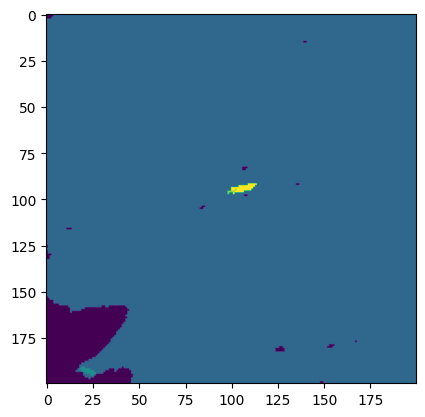

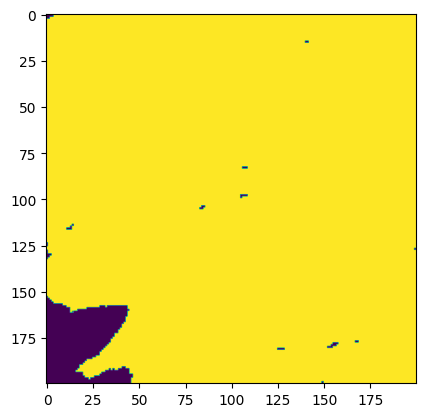

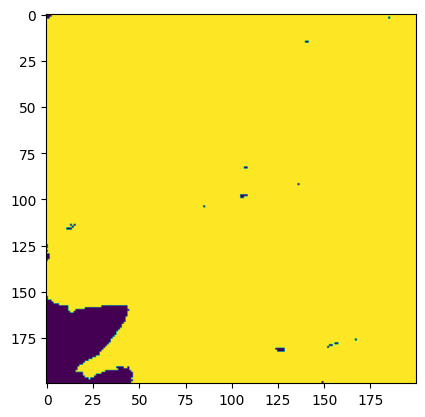

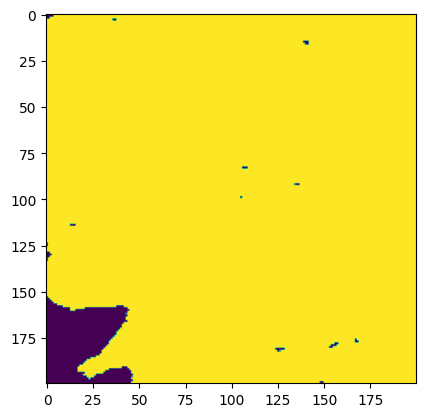

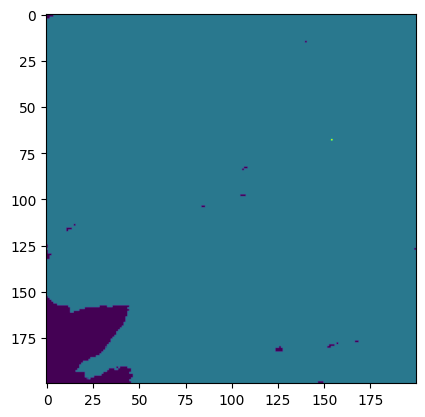

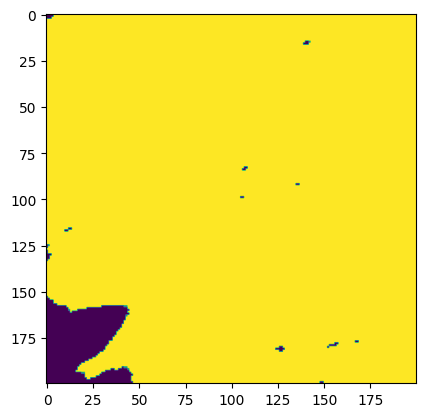

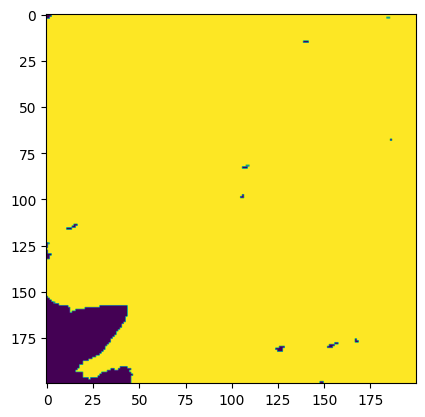

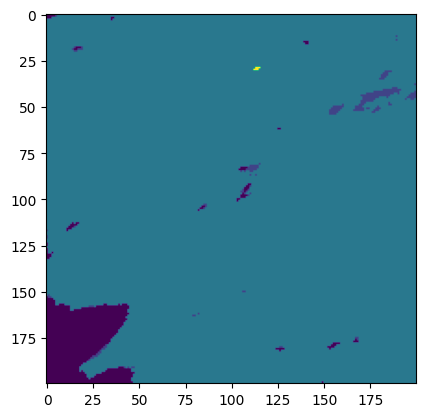

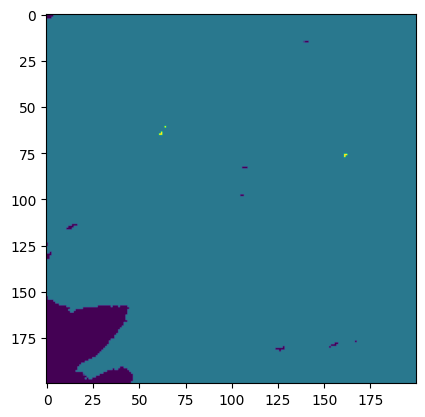

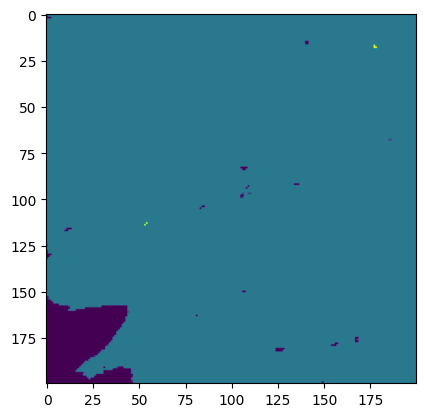

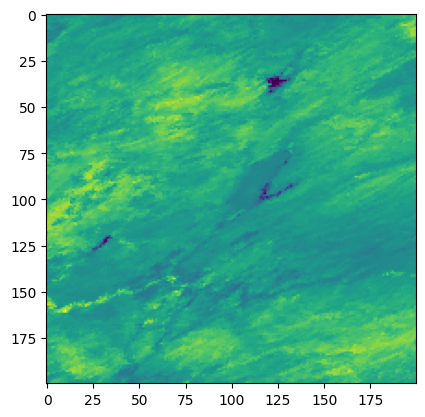

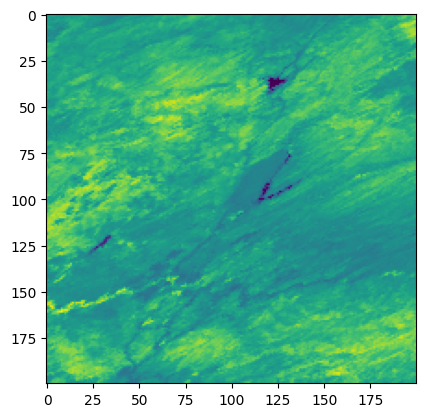

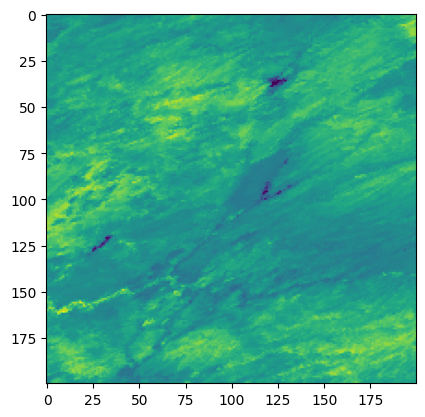

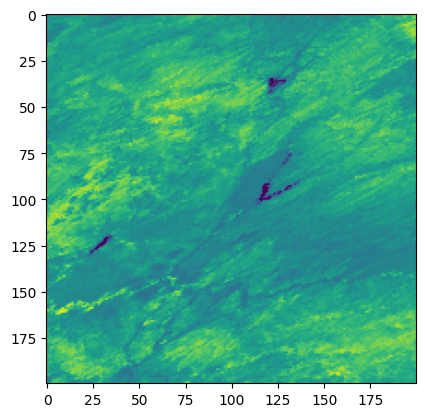

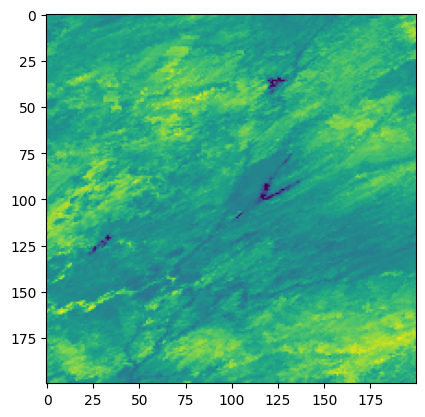

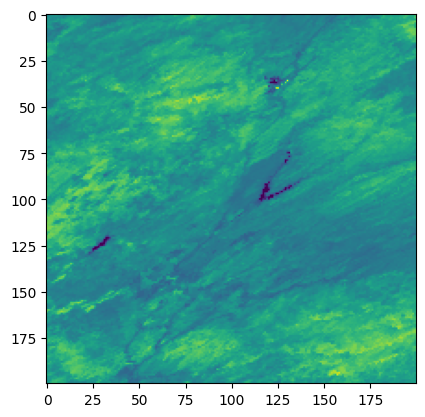

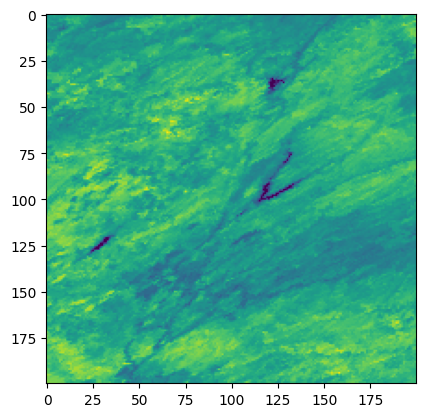

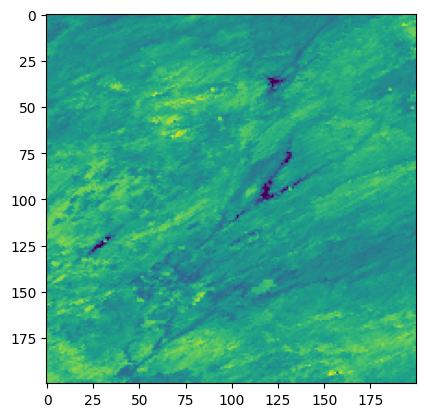

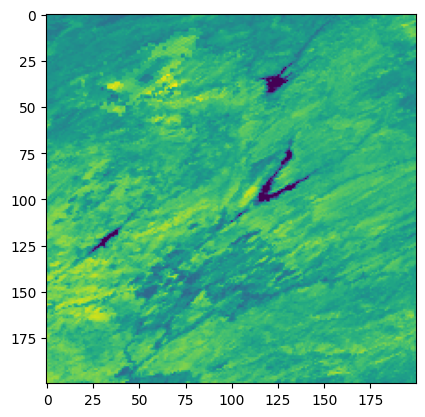

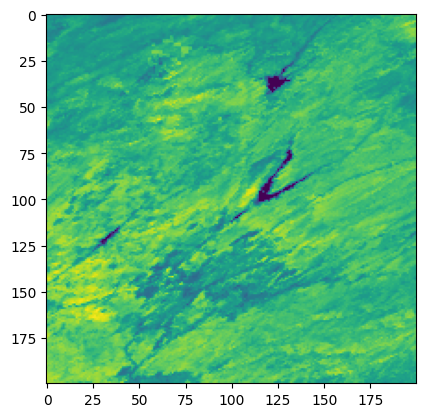

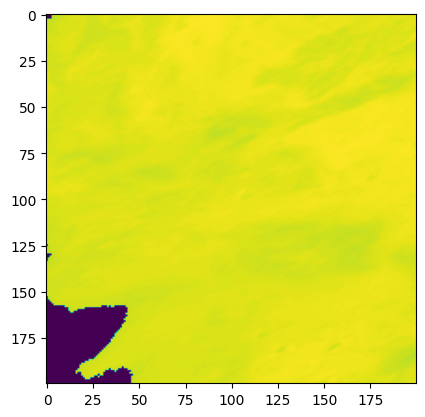

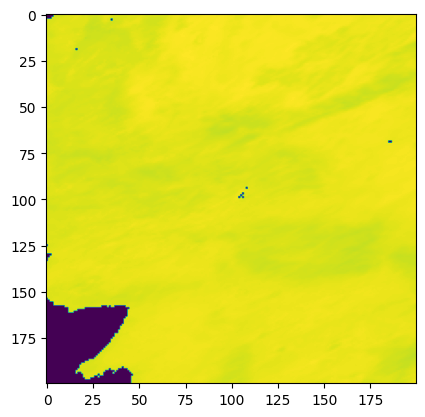

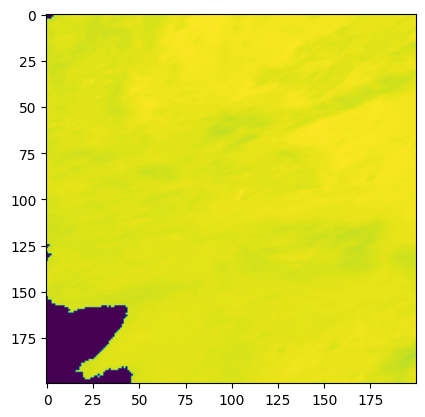

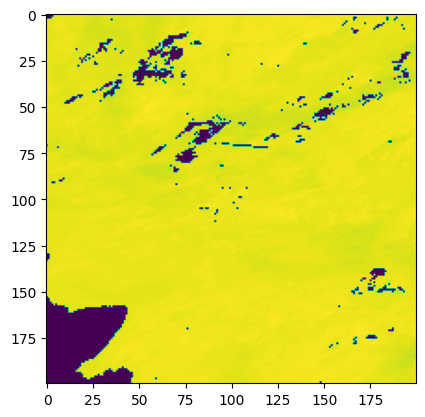

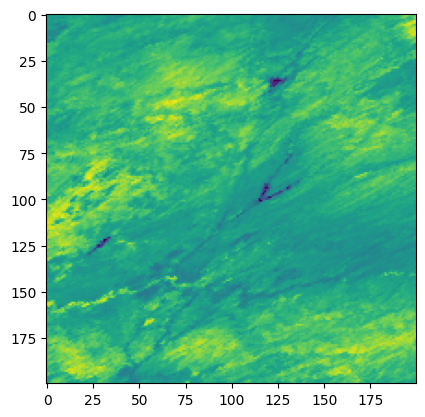

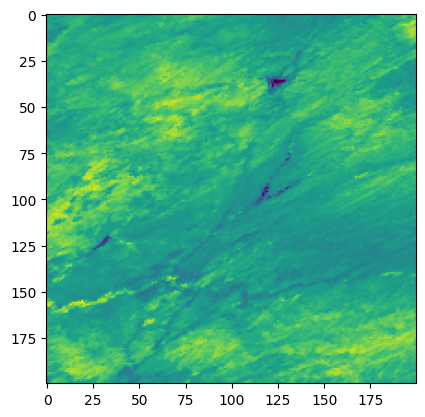

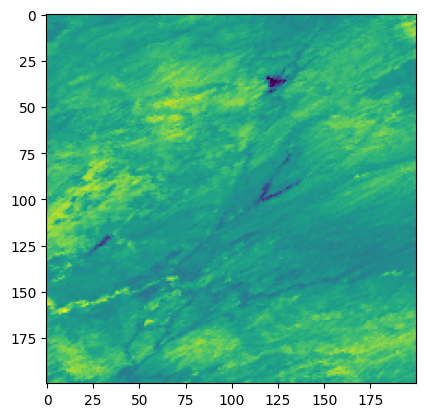

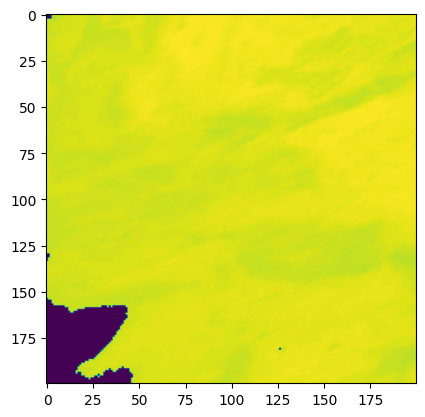

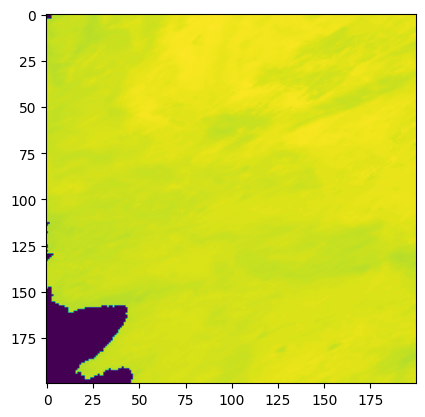

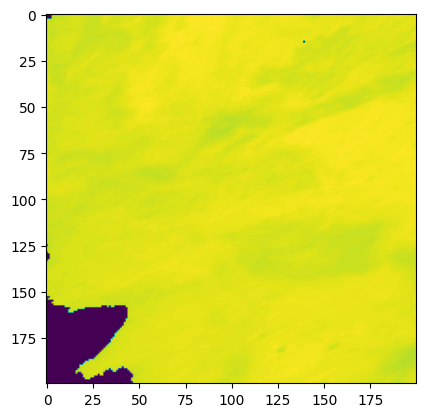

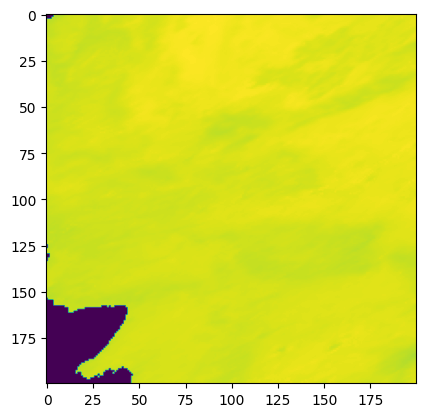

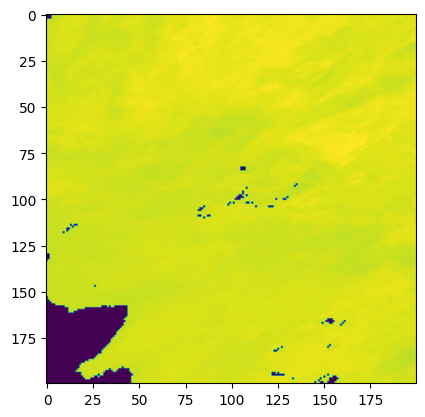

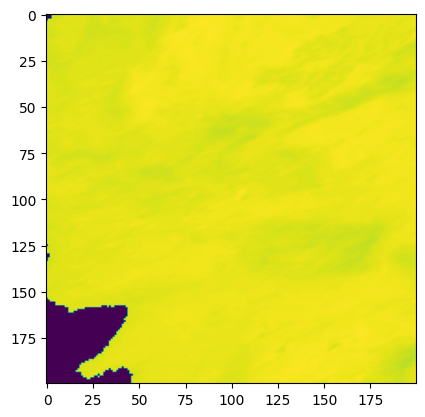

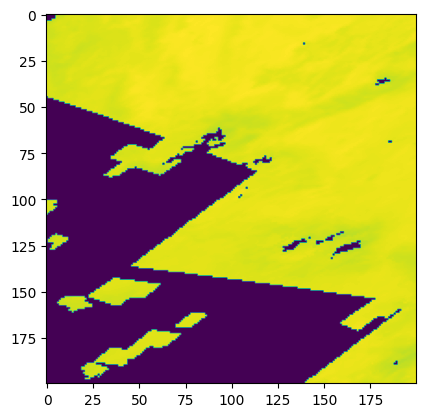

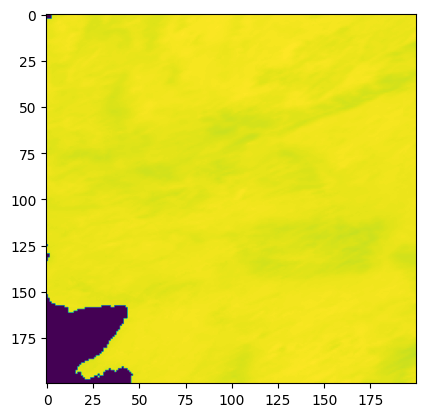

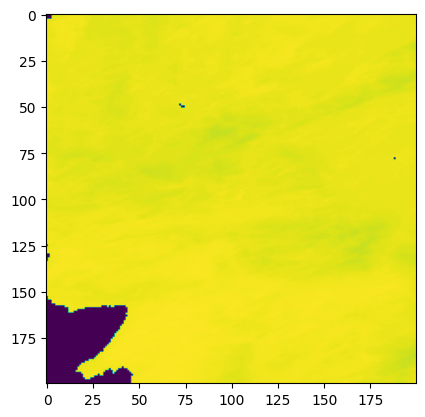

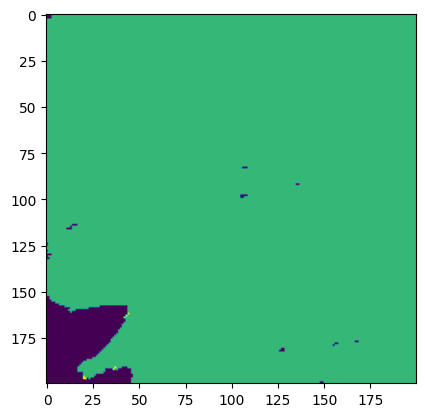

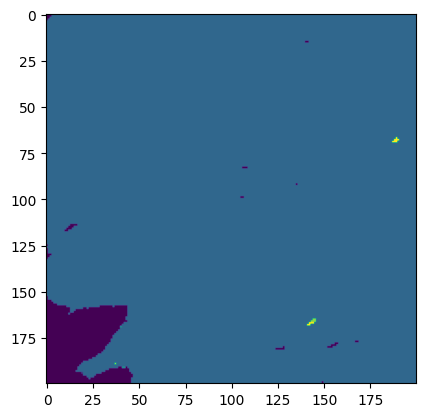

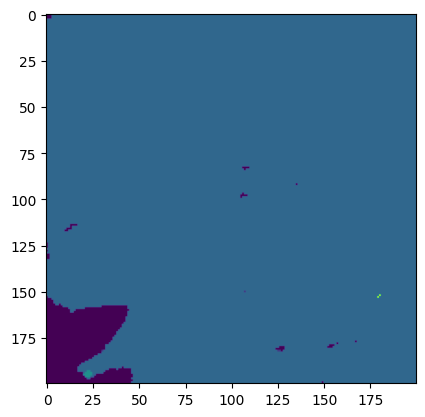

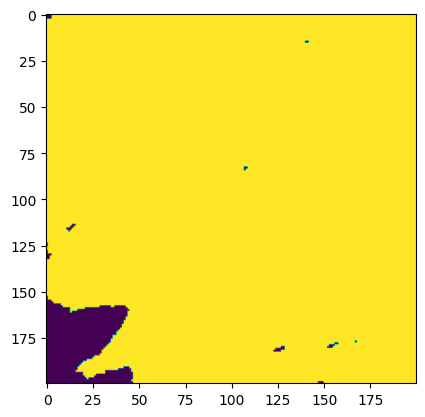

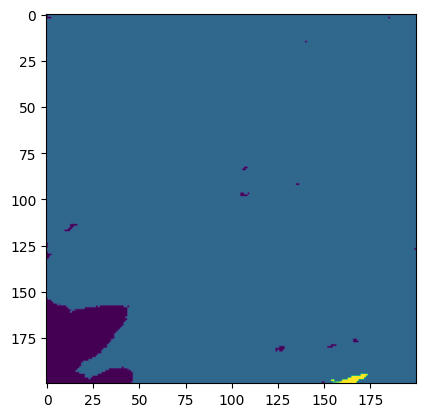

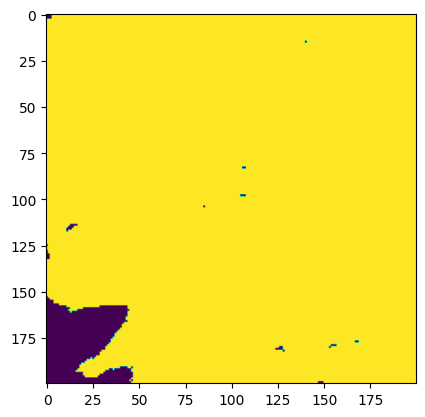

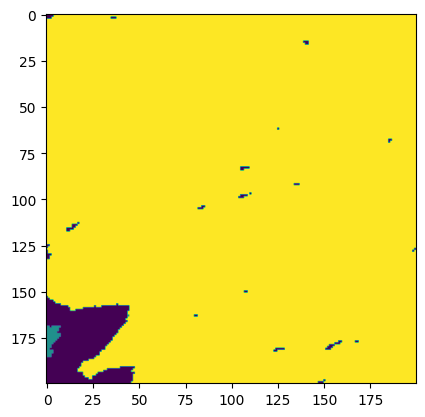

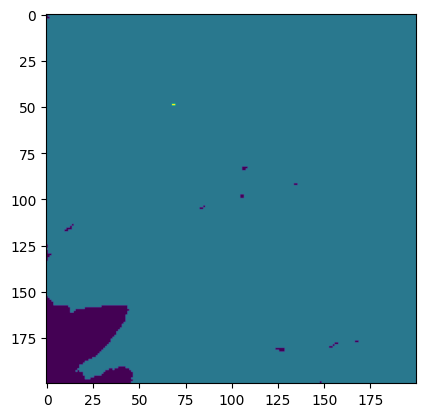

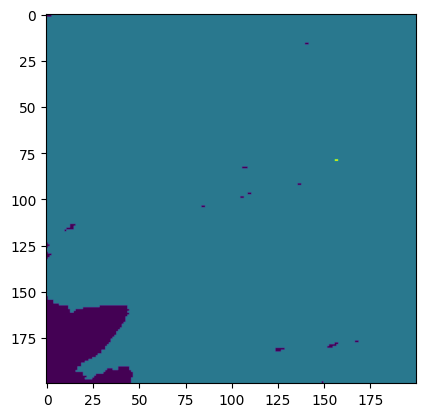

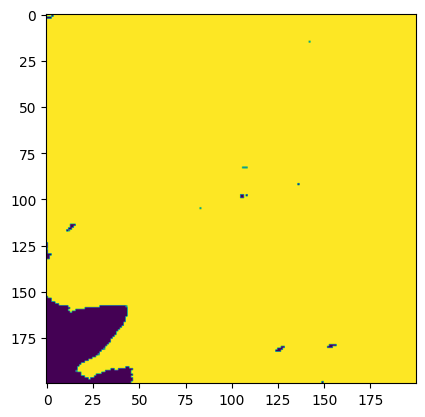

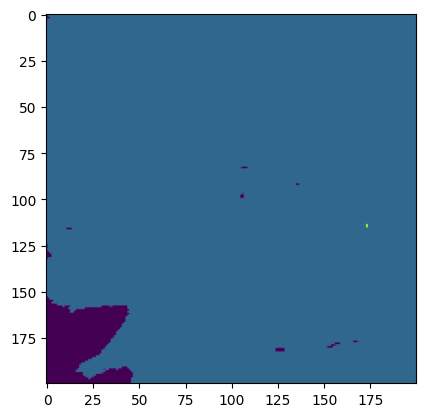

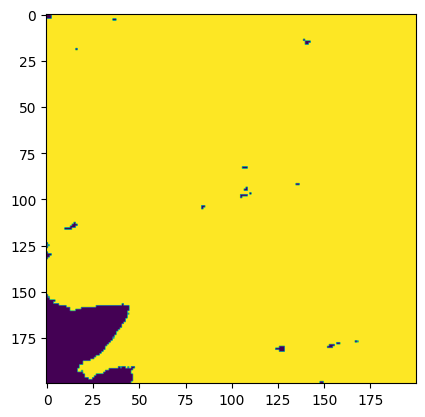

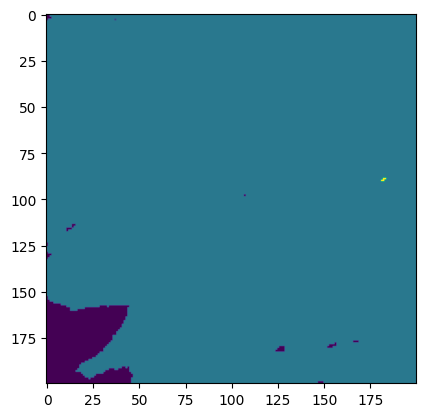

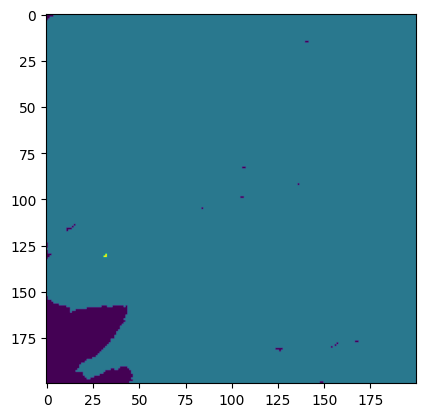

================= downloading  /home/fun/wildfire_data/Moc_Fire_2020-08-20==================
2020-06-21
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2020.06.21/
download error  404
2020-06-22
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2020.06.22/
download error  404
2020-06-23
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2020.06.23/
download error  404
2020-06-24
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2020.06.24/
download error  404
2020-06-25
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2020.06.25/
writing to /home/fun/wildfire_data/Moc_Fire_2020-08-20/fires_index_MOD13Q1.006_2020-06-25.html
2020-07-11
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2020.07.11/
writing to /home/fun/wildfire_data/Moc_Fire_2020-08-20/fires_index_MOD13Q1.006_2020-07-11.html
2020-07-27
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2020.07.27/
writing to /home/fun/wildfire_data/

In [ ]:

# veg index: MOD13Q1.006  ,  16d  , 'https://e4ftl01.cr.usgs.gov/MOLT/'
# land temporature: MOD11A2.006, 8d , , 'https://e4ftl01.cr.usgs.gov/MOLT/'
# burned area :  MCD64A1.006, 1m,  'https://e4ftl01.cr.usgs.gov/MOTA/'
# firemask: MOD14A2.006, 8d , 'https://e4ftl01.cr.usgs.gov/MOLT/'

# MOD_ID = 'MOD14A2.006'
# dt = '8d'  #8d,16d, 1m
# urlprefix = 'https://e4ftl01.cr.usgs.gov/MOLT/'
# wildfire = '/home/fun/wildfire_data/Saddle_Ridge_Fire_2019-10-10/'
# download_one_fire(wildfire , MOD_ID, dt, urlprefix)

# download everything once testing is done
radius = 25

# wildfires = glob('/home/fun/wildfire_data/*')

# for wildfire in wildfires:
#     print ('================= downloading  ' + wildfire + '==================')
# #         download_one_fire(wildfire +'/', MOD_ID, dt, urlprefix ) 
#     download_one_fire(wildfire +'/', 'MOD13Q1.006', '16d', 'https://e4ftl01.cr.usgs.gov/MOLT/' ) # vegi index
#     download_one_fire(wildfire +'/', 'MOD11A2.006', '16d', 'https://e4ftl01.cr.usgs.gov/MOLT/' )  # land temporature
# #         download_one_fire(wildfire +'/', 'MCD64A1.006', '1m', 'https://e4ftl01.cr.usgs.gov/MOTA/' ) #burned area
download_one_fire(wildfire +'/', 'MOD14A2.006', '16d', 'https://e4ftl01.cr.usgs.gov/MOLT/' ) # firemask
write_imgs(wildfire, radius)


wildfire= '/home/fun/wildfire_data/Railroad_Fire_2017-08-29'
download_one_fire(wildfire +'/', 'MOD13Q1.006', '16d', 'https://e4ftl01.cr.usgs.gov/MOLT/' )
write_imgs(wildfire, radius)
    
    

In [51]:
h08v04_info = dict([
    ('ll_lon', -131.0149),
    ('ll_lat', 39.7081),
    ('ul_lon', -156.8405),
    ('ul_lat', 49.8983),
    ('ur_lon', -140.2398),
    ('ur_lat', 50.1258),
    ('lr_lon', -117.2848),
    ('lr_lat', 39.8699),
    ('lat_delta', 10),
    ('lat_min', 40),
    ('lat_max', 50),
])

h08v05_info = dict([           
    ('ll_lon', -115.3696),
    ('ll_lat', 29.8308),
    ('ul_lon', -130.5407),
    ('ul_lat', 40.0000),
    ('ur_lon', -117.3606),
    ('ur_lat', 40.0852),
    ('lr_lon', -103.6998),
    ('lr_lat', 29.9063),
    ('lat_delta', 10),
    ('lat_min', 30),
    ('lat_max', 40),
])

def get_coords(lat, lon, MOD):
    lon_index = 0
    lat_index = 0
    if (h08v05_info['lat_min'] < lat <= h08v05_info['lat_max']): 
        MOD_lat = MOD + '_h08v05_lat'
        MOD_lon = MOD + '_h08v05_lon'
    else:
        MOD_lat = MOD + '_h08v04_lat'
        MOD_lon = MOD + '_h08v04_lon'
    while coords[MOD_lat][lat_index][0] > lat:
        lat_index += 1
    while coords[MOD_lon][lat_index][lon_index] < lon:
        lon_index += 1
    # print(coords[MOD_lat][lat_index][lon_index], coords[MOD_lon][lat_index][lon_index])
    return lat_index, lon_index

def get_subimg(lat, lon, radius, hdf_link, MOD):
    lat_index, lon_index = get_coords(lat, lon, MOD)
    hdf = SD(hdf_link)
    ndvi = hdf.select(0).get()
    # print(lat_index, lon_index)
    subimg = ndvi[lat_index-radius:lat_index+radius, lon_index-radius:lon_index+radius]
    return subimg

def load_lon_lat(txt):
    arr = np.loadtxt(txt, str)
    arr = np.char.replace(arr, ',', '')
    arr = arr.astype(float)
    length = int((arr.shape[0]) ** 0.5)
    arr = np.reshape(arr, (length, length))
    
    return arr

In [52]:
coords = dict()
txts = glob('/home/fun/wildfire_coords/*.txt')
for txt in txts:
    name = txt[-22:-4]
    arr = load_lon_lat(txt)
    coords[name] = arr

ValueError: cannot reshape array of size 1000 into shape (31,31)

In [49]:
def write_imgs(folder, radius):
    profile = folder + '/profile.json'
    with open(profile) as f:
        prof = json.load(f)
        lat = prof['info']['latitude']
        lon = prof['info']['longitude']
    if (h08v05_info['lat_min'] < lat <= h08v05_info['lat_max']): 
        tile = 'MOD*h08v05*'
    else:
        tile = 'MOD*h08v04*'
    mod_link = folder + '/' + tile
    mods = glob(mod_link)
    for mod in mods: 
        date = datetime.datetime(int(mod[-36:-32]), 1, 1) + datetime.timedelta(days = int(mod[-32:-29])-1)
        subimg = get_subimg(lat, lon, radius, mod, mod[-45:-38])
        file = folder + '/' + mod[-45:-38] + '_' + date.strftime('%Y-%m-%d') + '.npy'
        np.save(file, subimg)
        img = plt.imshow(subimg)
        plt.show()
        if os.path.isfile(mod):
            os.remove(mod)
        

In [28]:
os.remove('/home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07/MOD*.hdf')

FileNotFoundError: [Errno 2] No such file or directory: '/home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07/MOD*.hdf'

In [6]:
# Grape_Fire_2018-04-24
# Rattlesnake_Fire_2017-09-07
wildfire = '/home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07/'
download_one_fire(wildfire +'/', 'MOD13Q1.006', '16d', 'https://e4ftl01.cr.usgs.gov/MOLT/' ) # vegi index
download_one_fire(wildfire +'/', 'MOD11A2.006', '16d', 'https://e4ftl01.cr.usgs.gov/MOLT/' )  # land temporature
# download_one_fire(wildfire +'/', 'MCD64A1.006', '1m', 'https://e4ftl01.cr.usgs.gov/MOTA/' ) #burned area
download_one_fire(wildfire +'/', 'MOD14A2.006', '16d', 'https://e4ftl01.cr.usgs.gov/MOLT/' ) # firemask




2017-08-22
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2017.08.22/
download error  404
2017-08-23
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2017.08.23/
download error  404
2017-08-24
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2017.08.24/
download error  404
2017-08-25
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2017.08.25/
download error  404
2017-08-26
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2017.08.26/
download error  404
2017-08-27
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2017.08.27/
download error  404
2017-08-28
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2017.08.28/
download error  404
2017-08-29
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2017.08.29/
writing to /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07//fires_index_MOD13Q1.006_2017-08-29.html
2017-09-14
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q

downloading  MOD13Q1.A2017321.h08v05.006.2017337222143.hdf to  /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07//
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2017.11.17/MOD13Q1.A2017321.h08v05.006.2017337222143.hdf
writing to /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07//MOD13Q1.A2017321.h08v05.006.2017337222143.hdf
parsing /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07/fires_index_MOD13Q1.006_2017-12-03.html
downloading  MOD13Q1.A2017337.h08v04.006.2017353223715.hdf to  /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07//
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2017.12.03/MOD13Q1.A2017337.h08v04.006.2017353223715.hdf
writing to /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07//MOD13Q1.A2017337.h08v04.006.2017353223715.hdf
downloading  MOD13Q1.A2017337.h08v05.006.2017353223230.hdf to  /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07//
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD13Q1.006/2017.12.03/MOD13Q1.A201733

parsing /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07/fires_index_MOD11A2.006_2017-09-30.html
downloading  MOD11A2.A2017273.h08v04.006.2017282032839.hdf to  /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07//
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2017.09.30/MOD11A2.A2017273.h08v04.006.2017282032839.hdf
writing to /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07//MOD11A2.A2017273.h08v04.006.2017282032839.hdf
downloading  MOD11A2.A2017273.h08v05.006.2017282033343.hdf to  /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07//
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/2017.09.30/MOD11A2.A2017273.h08v05.006.2017282033343.hdf
writing to /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07//MOD11A2.A2017273.h08v05.006.2017282033343.hdf
parsing /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07/fires_index_MOD11A2.006_2017-10-16.html
downloading  MOD11A2.A2017289.h08v04.006.2017298032811.hdf to  /home/fun/wildfire_data/Rattlesnake_Fire_20

parsing /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07/fires_index_MOD11A2.006_2017-10-16.html
parsing /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07/fires_index_MOD11A2.006_2017-11-01.html
parsing /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07/fires_index_MOD11A2.006_2017-11-17.html
parsing /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07/fires_index_MOD11A2.006_2017-12-03.html
parsing /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07/fires_index_MOD11A2.006_2017-12-19.html
parsing /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07/fires_index_MOD11A2.006_2018-01-09.html
parsing /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07/fires_index_MCD64A1.006_2017-09-01.html
downloading  MCD64A1.A2017244.h08v04.006.2017314191617.hdf to  /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07//
downloading file  https://e4ftl01.cr.usgs.gov/MOTA/MCD64A1.006/2017.09.01/MCD64A1.A2017244.h08v04.006.2017314191617.hdf
writing to /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07/

writing to /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07//fires_index_MOD14A2.006_2018-01-09.html
parsing /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07/fires_index_MOD13Q1.006_2017-08-29.html
parsing /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07/fires_index_MOD13Q1.006_2017-09-14.html
parsing /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07/fires_index_MOD13Q1.006_2017-09-30.html
parsing /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07/fires_index_MOD13Q1.006_2017-10-16.html
parsing /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07/fires_index_MOD13Q1.006_2017-11-01.html
parsing /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07/fires_index_MOD13Q1.006_2017-11-17.html
parsing /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07/fires_index_MOD13Q1.006_2017-12-03.html
parsing /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07/fires_index_MOD13Q1.006_2017-12-19.html
parsing /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07/fires_index_MOD13Q1.006_2018-01-17.h

writing to /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07//MOD14A2.A2017353.h08v04.006.2017361224121.hdf
downloading  MOD14A2.A2017353.h08v05.006.2017361223859.hdf to  /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07//
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2017.12.19/MOD14A2.A2017353.h08v05.006.2017361223859.hdf
writing to /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07//MOD14A2.A2017353.h08v05.006.2017361223859.hdf
parsing /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07/fires_index_MOD14A2.006_2018-01-09.html
downloading  MOD14A2.A2018009.h08v04.006.2018017224059.hdf to  /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07//
downloading file  https://e4ftl01.cr.usgs.gov/MOLT/MOD14A2.006/2018.01.09/MOD14A2.A2018009.h08v04.006.2018017224059.hdf
writing to /home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07//MOD14A2.A2018009.h08v04.006.2018017224059.hdf
downloading  MOD14A2.A2018009.h08v05.006.2018017224302.hdf to  /home/fun/wildfire_data/Rattlesna

In [42]:
radius = 100
# Kincade_Fire_2019-10-23
# Warner_Mountain_Lightning_2017-07-23
# Soberanes_Fire_2016-07-22
# Butte_Fire_2015-09-09
# Thomas_Fire_2017-12-04
# Ranch_Fire_Mendocino_Complex_2018-07-27
# Sand_Fire_2014-07-25
write_imgs('/home/fun/wildfire_data/Rattlesnake_Fire_2017-09-07', radius)


SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (342874700.py, line 4)

----- MOD13Q1 : Vegetation Index hdf -----------
idx: 0     sds: 250m 16 days NDVI
idx: 1     sds: 250m 16 days EVI
idx: 2     sds: 250m 16 days VI Quality
idx: 3     sds: 250m 16 days red reflectance
idx: 4     sds: 250m 16 days NIR reflectance
idx: 5     sds: 250m 16 days blue reflectance
idx: 6     sds: 250m 16 days MIR reflectance
idx: 7     sds: 250m 16 days view zenith angle
idx: 8     sds: 250m 16 days sun zenith angle
idx: 9     sds: 250m 16 days relative azimuth angle
idx: 10     sds: 250m 16 days composite day of the year
idx: 11     sds: 250m 16 days pixel reliability
----- MOD11A2 : Land Surface Temperature (LST) and Emissivity hdf -----------
idx: 0     sds: LST_Day_1km
idx: 1     sds: QC_Day
idx: 2     sds: Day_view_time
idx: 3     sds: Day_view_angl
idx: 4     sds: LST_Night_1km
idx: 5     sds: QC_Night
idx: 6     sds: Night_view_time
idx: 7     sds: Night_view_angl
idx: 8     sds: Emis_31
idx: 9     sds: Emis_32
idx: 10     sds: Clear_sky_days
idx: 11     sds: Clear_sky

<Figure size 640x480 with 0 Axes>

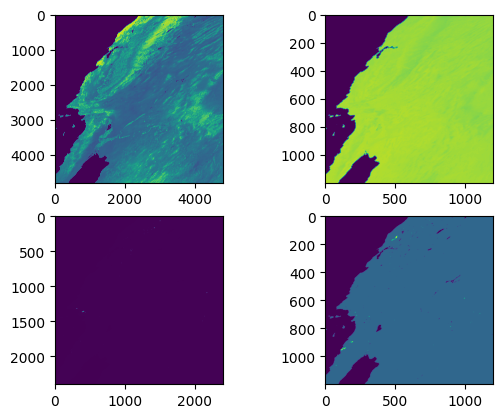

In [109]:
hdf_vegInd = SD('/home/fun/wildfire_data/Saddle_Ridge_Fire_2019-10-10/MOD13Q1.A2019305.h08v05.006.2019323202019.hdf')
hdf_temperature = SD('/home/fun/wildfire_data/Saddle_Ridge_Fire_2019-10-10/MOD11A2.A2019297.h08v05.006.2019306035514.hdf')
hdf_burned = SD('/home/fun/wildfire_data/Saddle_Ridge_Fire_2019-10-10/MCD64A1.A2019305.h08v05.006.2020005194524.hdf')
hdf_fire = SD('/home/fun/wildfire_data/Saddle_Ridge_Fire_2019-10-10/MOD14A2.A2019297.h08v05.006.2019305235501.hdf')

print('----- MOD13Q1 : Vegetation Index hdf -----------')
hdf_dict = hdf_vegInd.datasets()
for idx,sds in enumerate(hdf_dict.keys()):
    print ('idx:', idx, '    sds:', sds)
 
print('----- MOD11A2 : Land Surface Temperature (LST) and Emissivity hdf -----------')
hdf_dict = hdf_temperature.datasets()
for idx,sds in enumerate(hdf_dict.keys()):
    print ('idx:', idx, '    sds:', sds)

print('----- MCD64A1 : burned area hdf -----------')
hdf_dict = hdf_burned.datasets()
for idx,sds in enumerate(hdf_dict.keys()):
    print ('idx:', idx, '    sds:', sds)

print('----- MOD14A2 : fire hdf -----------')
hdf_dict = hdf_fire.datasets()
for idx,sds in enumerate(hdf_dict.keys()):
    print ('idx:', idx, '    sds:', sds)

    
    
ndvi = hdf_vegInd.select(0).get()
LST = hdf_temperature.select(0).get()
burned = hdf_burned.select(0).get()
fire = hdf_fire.select(0).get()

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0,0].imshow(ndvi)
axarr[0, 1].imshow(LST)
axarr[1,0].imshow(burned)
axarr[1,1].imshow(fire) 



In [17]:
coords = dict()
txts = glob('/home/fun/wildfire_coords/*.txt')
for txt in txts:
    name = txt[-22:-4]
    arr = load_lon_lat(txt)
    coords[name] = arr
    


In [14]:
h08v04_info = dict([
    ('ll_lon', -131.0149),
    ('ll_lat', 39.7081),
    ('ul_lon', -156.8405),
    ('ul_lat', 49.8983),
    ('ur_lon', -140.2398),
    ('ur_lat', 50.1258),
    ('lr_lon', -117.2848),
    ('lr_lat', 39.8699),
    ('lat_delta', 10),
    ('lat_min', 40),
    ('lat_max', 50),
])

h08v05_info = dict([           
    ('ll_lon', -115.3696),
    ('ll_lat', 29.8308),
    ('ul_lon', -130.5407),
    ('ul_lat', 40.0000),
    ('ur_lon', -117.3606),
    ('ur_lat', 40.0852),
    ('lr_lon', -103.6998),
    ('lr_lat', 29.9063),
    ('lat_delta', 10),
    ('lat_min', 30),
    ('lat_max', 40),
])

def get_coords(lat, lon, MOD):
    lon_index = 0
    lat_index = 0
    if (h08v05_info['lat_min'] < lat <= h08v05_info['lat_max']): 
        MOD_lat = MOD + '_h08v05_lat'
        MOD_lon = MOD + '_h08v05_lon'
    else:
        MOD_lat = MOD + '_h08v04_lat'
        MOD_lon = MOD + '_h08v04_lon'
    while coords[MOD_lat][lat_index][0] > lat:
        lat_index += 1
    while coords[MOD_lon][lat_index][lon_index] < lon:
        lon_index += 1
    # print(coords[MOD_lat][lat_index][lon_index], coords[MOD_lon][lat_index][lon_index])
    return lat_index, lon_index

def get_subimg(lat, lon, radius, hdf_link, MOD):
    lat_index, lon_index = get_coords(lat, lon, MOD)
    hdf = SD(hdf_link)
    ndvi = hdf.select(0).get()
    # print(lat_index, lon_index)
    subimg = ndvi[lat_index-radius:lat_index+radius, lon_index-radius:lon_index+radius]
    return subimg

def load_lon_lat(txt):
    arr = np.loadtxt(txt, str)
    arr = np.char.replace(arr, ',', '')
    arr = arr.astype(float)
    length = int((arr.shape[0]) ** 0.5)
    arr = np.reshape(arr, (length, length))
    
    return arr

In [15]:
def write_imgs(folder, radius):
    profile = folder + '/profile.json'
    with open(profile) as f:
        prof = json.load(f)
        lat = prof['info']['latitude']
        lon = prof['info']['longitude']
    if (h08v05_info['lat_min'] < lat <= h08v05_info['lat_max']): 
        tile = '*h08v05*'
    else:
        tile = '*h08v04*'
    mod_link = folder + '/' + tile
    mods = glob(mod_link)
    for mod in mods: 
        date = datetime.datetime(int(mod[-36:-32]), 1, 1) + datetime.timedelta(days = int(mod[-32:-29])-1)
        print(mod[-36:-32])
        subimg = get_subimg(lat, lon, radius, mod, mod[-45:-38])
        file = folder + '/' + mod[-45:-38] + '_' + date.strftime('%Y-%m-%d') + '.npy'
        np.save(file, subimg)
        img = plt.imshow(subimg)
        plt.show()

2019


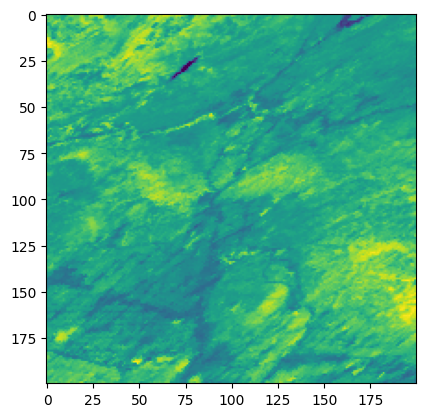

2019


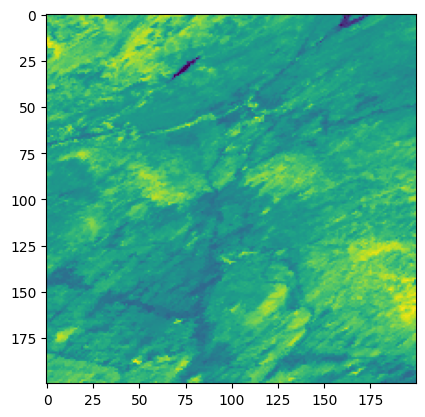

2019


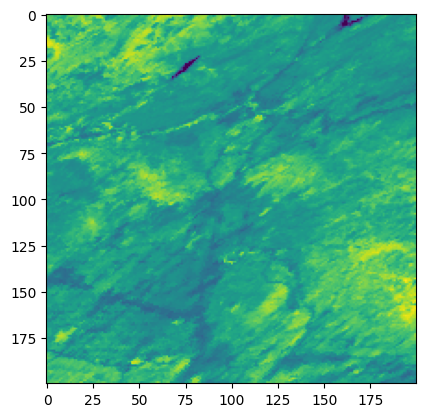

2019


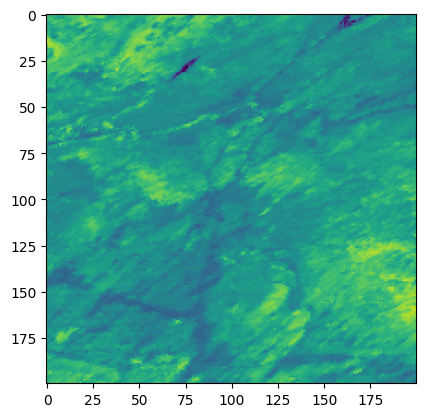

2019


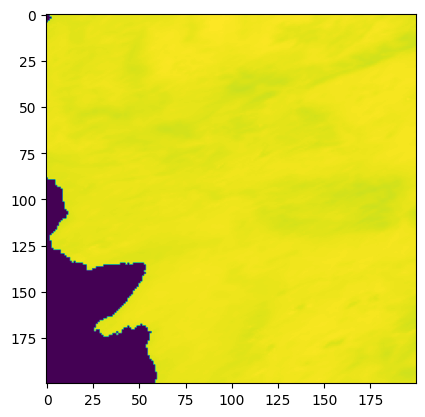

2019


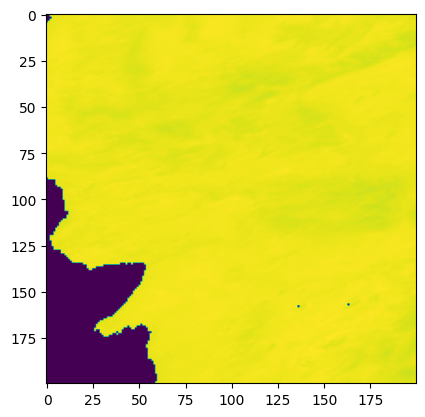

2019


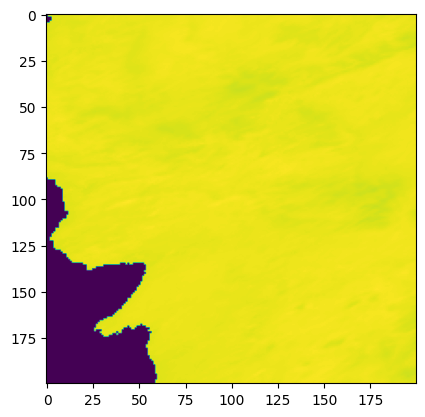

2019


KeyError: 'MCD64A1_h08v05_lat'

In [18]:
radius = 100
write_imgs('/home/fun/wildfire_data/Saddle_Ridge_Fire_2019-10-10', radius)

In [90]:
hdf_burn = SD('/home/fun/wildfire_data/Saddle_Ridge_Fire_2019-10-10/MCD64A1.A2019305.h08v05.006.2020005194524.hdf')
burn = hdf_burn.select(3).get()
print(burn[1:2010,2001:2010])


[[282 283 283 ...  -2  -2  -2]
 [282 283 283 ...  -2  -2  -2]
 [282 283 283 ...  -2  -2  -2]
 ...
 [284 284 284 ... 283 284 284]
 [283 283 283 ... 284 284 284]
 [283 283 283 ... 284 285 285]]


PNG
(816, 1056)
RGBA
<class 'numpy.ndarray'>
(1056, 816, 4)


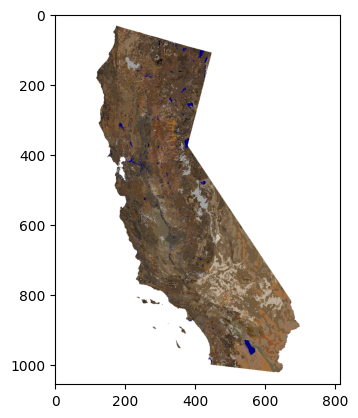

In [132]:

from PIL import Image
from numpy import asarray
img = Image.open('/home/fun/plant-predictor/Soil_CA/CA-015-light.png')
 
# summarize some details about the image
print(img.format)
print(img.size)
print(img.mode)

numpydata = asarray(img)
 
print(type(numpydata))
print(numpydata.shape)

im = plt.imshow(numpydata)
plt.show()

In [286]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import json

In [55]:
def load_npy(folder): # used for MOD14A2, MOD13Q1
    mod14 = folder + '/MOD14A2*.npy'
    mod13 = folder + '/MOD13Q1*.npy'
    mod14g = glob.glob(mod14)
    mod13g = glob.glob(mod13)
    
    times = min(len(mod14g), len(mod13g))
    if times < frames:
        return
    res = np.zeros(shape=(1, times, dims, dims, channels))
    for i in range(times):
        arr14 = np.load(mod14g[i])
        arr13 = np.load(mod13g[i])
        if (arr14.shape != (dims, dims)) or (arr13.shape != (dims, dims)):
            return
        arr14 = arr14[np.newaxis, np.newaxis, :, :]
        arr13 = arr13[np.newaxis, np.newaxis, :, :]
        res[:, i, :, :, 0] = arr14
        res[:, i, :, :, 1] = arr13

    print(res.shape)
    return res

In [308]:
import numpy as np
import matplotlib.pyplot as plt
import umap
import geopandas as gpd
import glob
from glob import glob
import os

path = '/home/fun/wildfire_data/*'
files = glob(path)
file_list = np.array([])
fire_names = np.array([])
fire_locations = np.zeros(shape=(0, 4)) # lat, lon, burned area, year start
# fire_locations = [39.60953908155403, -121.03757694728168, 0.] #fill the first record
count = 0
per_count = 0
ndvi_count = 0
ref_count = 0
mod11_count =0
complete_data_count = 0
for file in files:
    
    prof = file + '/profile.json'
    try:
        f = open(prof)
        info = json.load(f)
        end = datetime.datetime.strptime(info['end'], '%Y-%m-%d')
        cutoff_date = end.replace(year=2021, month=2, day=1)
        if(info['info']['acres_burned'] >= 3000) and (end <= cutoff_date):
            
            burn = info['info']['acres_burned']
            start = datetime.datetime.strptime(info['start'], '%Y-%m-%d')
            end = datetime.datetime.strptime(info['end'], '%Y-%m-%d')
            fire =[info['info']['latitude'], info['info']['longitude'], burn, start.year]
            fire_locations = np.vstack((fire_locations, fire))
#             print('fire/burn/start_year: ',file[-(len(file)-24):], "\t" , burn, "\t" ,start.year)
            print(start.year, "\t", burn,end,"    \t", file[-(len(file)-24):], "    \t", info['info']['latitude'], info['info']['longitude'])
            count = count +1
        
            precip_file = file +'/monthly_percip.npy'
            MOD_ref_files = glob(file + '/r_*.npy')
            MOD11_files = glob(file + '/MOD11*.npy')
            MOD13_ratio_files = glob(file + '/ratio_MOD13Q1_*.npy')
         
            
            if (os.path.isfile(precip_file) and (len(MOD11_files) == 25) and (len(MOD_ref_files) == 12) and (len(MOD13_ratio_files) ==25)) :
                complete_data_count = complete_data_count +1
                fire_names = np.append(fire_names, file[-(len(file)-24):])
                
            if os.path.isfile(precip_file):
                per_count = per_count +1
            else: 
#                 print(start.year, "\t", burn,end,"    \t", file[-(len(file)-24):], "    \t", info['info']['latitude'], info['info']['longitude'])
                print("NOOOOOOO precip file")
                
            if len(MOD13_ratio_files) == 25 :
                ndvi_count = ndvi_count +1
            else:
#                 print(start.year, "\t", burn,end,"    \t", file[-(len(file)-24):], "    \t", info['info']['latitude'], info['info']['longitude'])
                print('ndvi nooooooooooo', len(MOD13_ratio_files))
            
            if len(MOD11_files) == 25 :
                mod11_count = mod11_count +1
            else:
#                 print(start.year, "\t", burn,end,"    \t", file[-(len(file)-24):], "    \t", info['info']['latitude'], info['info']['longitude'])
                print('mod11 nooooooooooo',len(MOD11_files))
            
            if(len(MOD_ref_files) != 12):
#                 print(start.year, "\t", burn,end,"    \t", file[-(len(file)-24):], "    \t", info['info']['latitude'], info['info']['longitude'])
                print('ref nooooooooo',len(MOD_ref_files) )
            else:
                ref_count =ref_count+1
                    
                

    except:
        continue
print ("Total number of fires : " , count)
print(" monthly_percip file number " , per_count)
print(" ndvi file number " , ndvi_count)
print(" ref file number " , ref_count)
print(" mod11 file number " , mod11_count)
print('complete data', complete_data_count)
        
######################################################################################################################
################################### FIRES TO CHECK (4) -- NO REFERENCE NUMPY FILES ###################################
################################ 1. /home/fun/wildfire_data/Walker_Fire_2019-09-04  ##################################
################################ 2. /home/fun/wildfire_data/El_Dorado_Fire_2020-09-05  ###############################
################################ 3. /home/fun/wildfire_data/Tucker_Fire_2019-07-28  ##################################
################################ 4. /home/fun/wildfire_data/Taboose_Fire_2019-09-06  #################################

2020 	 1032648 2020-11-18 00:00:00     	 August_Complex_includes_Doe_Fire_2020-08-16     	 39.776 -122.673
2020 	 83261 2020-11-10 00:00:00     	 July_Complex_2020-07-24     	 41.699 -121.477
2019 	 77758 2020-03-03 00:00:00     	 Kincade_Fire_2019-10-23     	 38.792458 -122.780053
2018 	 63311 2019-10-25 00:00:00     	 Delta_Fire_2018-09-05     	 40.9425 -122.43
2020 	 56338 2020-10-16 00:00:00     	 Zogg_Fire_2020-09-27     	 40.53927 -122.56656
2019 	 54612 2019-10-24 00:00:00     	 Walker_Fire_2019-09-04     	 40.061389 -120.680556
mod11 nooooooooooo 0
2020 	 48088 2020-09-04 00:00:00     	 River_Fire_2020-08-16     	 36.60239 -121.62161
2020 	 47029 2020-08-27 00:00:00     	 Loyalton_Fire_2020-08-14     	 39.702438 -120.143473
2018 	 38008 2019-10-25 00:00:00     	 Klamathon_Fire_2018-07-05     	 41.893332 -122.534655
2017 	 36807 2019-10-25 00:00:00     	 Tubbs_Fire_Central_LNU_Complex_2017-10-08     	 38.60895 -122.62879
2020 	 31089 2020-09-29 00:00:00     	 Lake_Fire_2020-08-1

In [300]:
print(type(fire_names))
# print(fire_names)

idx = np.where(fire_names == 'Taboose_Fire_2019-09-06')
print('fire_index : ', idx[0][0])

<class 'numpy.ndarray'>
fire_index :  16


fire_index :  16
Taboose_Fire_2019-09-06


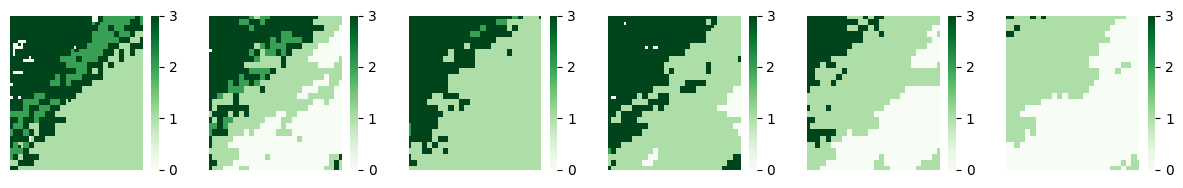

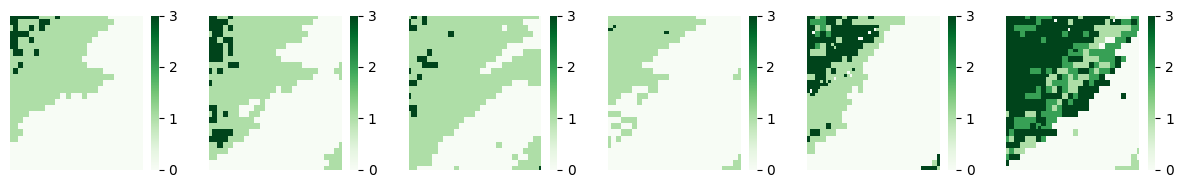

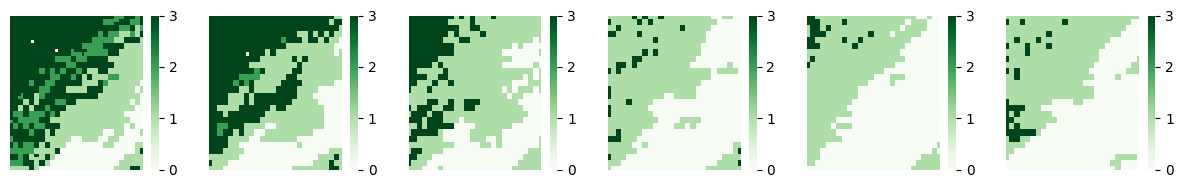

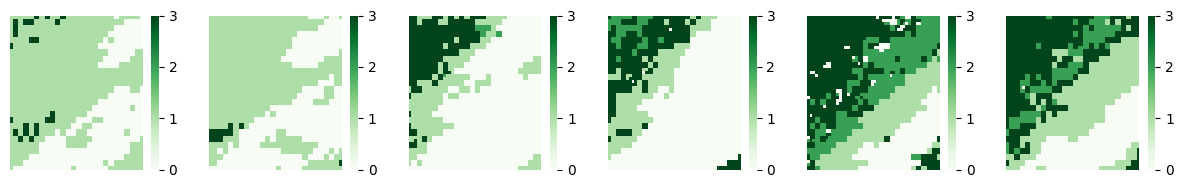

In [305]:
import pandas as pds

import matplotlib.pyplot as plt

dims = 50
frames = 25
channels = 2

idx = np.where(fire_names == 'Taboose_Fire_2019-09-06')
print('fire_index : ', idx[0][0])
fire_index = idx[0][0]
# bad data files:
# Taboose_Fire_2019-09-06
# Caples_Fire_2019-10-11
# Donnell_Fire_2018-08-01
# Empire_Fire_2017-08-01
# Boot_Fire_2018-09-04





# maybe use fires
# Hog_Fire_2020-07-18
# Eiler_Fire_2014-07-31
# Lion_Fire_2017-09-27
# Whaleback_Fire_2018-07-27
# Lions_Fire_2018-06-11
# Young_Fire_2017-08-07




# fire_names
folder = '/home/fun/wildfire_data/'+fire_names[fire_index]
# folder = '/home/fun/wildfire_data/'+'Taboose_Fire_2019-09-09'
print(fire_names[fire_index])



ndvi = folder + '/MOD13*.npy'
ndvi_g = glob(ndvi)
ndvi_g.sort()

data_qa = np.zeros(shape=(0,  3, dims, dims ))
for i in range(len(ndvi_g)):
    arr13_qa = np.load(ndvi_g[i])
#     print(ndvi_g[i],arr13_qa.shape)
    arr13_qa = arr13_qa[np.newaxis, :, :,:]
    data_qa = np.append(data_qa, arr13_qa, axis=0)
    
layer = 2

if layer == 2 :
    minVal = 0
    maxVal = 3
else:
    minVal = 0
    maxVal = 8000



min_v = np.min(data_qa[i, layer, :, :])       
max_v = np.max(data_qa[i, layer, :, :])    
f, axes = plt.subplots(1, 6, figsize=(15, 2))
for i in range(6):
    ax = sns.heatmap(data_qa[i, layer, :, :],  ax=axes[i], cmap='Greens', vmin =minVal , vmax = maxVal)
    ax.set_axis_off()
    
f, axes = plt.subplots(1, 6, figsize=(15, 2))
for i in range(6,12):
    ax =  sns.heatmap(data_qa[i, layer, :, :],  ax=axes[i-6], cmap='Greens', vmin = minVal, vmax = maxVal)
    ax.set_axis_off()
plt.show()

f, axes = plt.subplots(1, 6, figsize=(15, 2))
for i in range(12,18):
    ax =  sns.heatmap(data_qa[i, layer, :, :],  ax=axes[i-12], cmap='Greens', vmin = minVal, vmax = maxVal)
    ax.set_axis_off()
plt.show()

f, axes = plt.subplots(1, 6, figsize=(15, 2))
for i in range(18,24):
    ax =  sns.heatmap(data_qa[i, layer, :, :],  ax=axes[i-18], cmap='Greens', vmin = minVal, vmax = maxVal)
    ax.set_axis_off()
plt.show()

Young_Fire_2017-08-07
25
file name: Young Fire
burned area:  3142
start date: 2017-08-07
end date: 2018-01-09
burned area in %:  0.08268421052631579


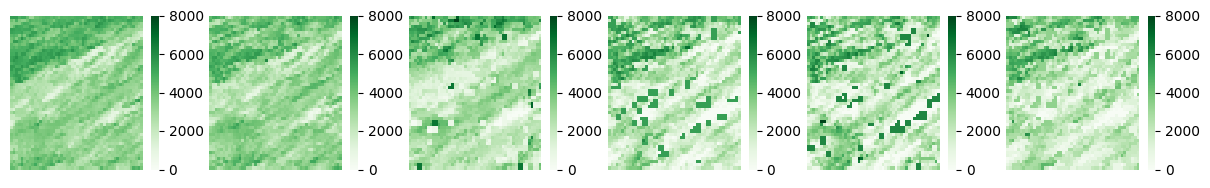

<Figure size 640x480 with 0 Axes>

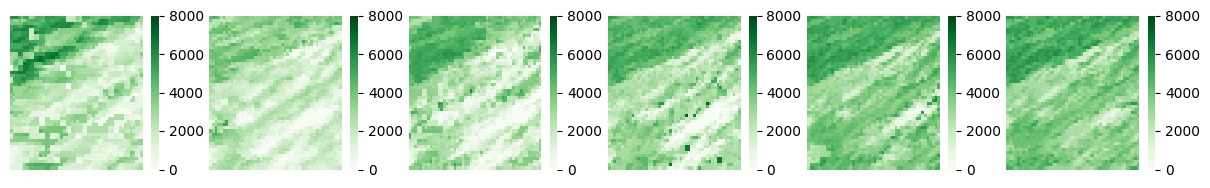

In [261]:
import pandas as pds

import matplotlib.pyplot as plt


# 

# fire_index = 0
# fire_names
folder = '/home/fun/wildfire_data/'+fire_names[fire_index]
# folder = '/home/fun/wildfire_data/'+'Loyalton_Fire_2020-08-14'
print(fire_names[fire_index])

ndvi_r = folder + '/ratio_*.npy'
ndvi_g = glob(ndvi_r)
ndvi_g.sort()

ndvi_ref = folder + '/r_*.npy'
ndvi_ref_g = glob(ndvi_ref)
ndvi_ref_g.sort()



# mod13 = folder + '/MOD13Q1*.npy'
# mod13g = glob.glob(mod13)
# mod13g.sort()
print(len(ndvi_g))

prof = folder + '/profile.json'
    
f = open(prof)
info = json.load(f)
print('file name: ' + info['name'])
print('burned area: ' , info['info']['acres_burned'])
print('start date: ' + info['start'])
print('end date: ' + info['end'])
print('burned area in %: ', info['info']['acres_burned']/38000)

data_ref = np.zeros(shape=(0,  channels, dims, dims ))
for i in range(len(ndvi_ref_g)):
    arr13_ref = np.load(ndvi_ref_g[i])
#     print(ndvi_ref_g[i])
    arr13_ref = arr13_ref[np.newaxis, 0:2, :,:]
    data_ref = np.append(data_ref, arr13_ref, axis=0)
min_ref = 0   
max_ref = 8000       
# min_ref = np.min(data_ref)       
# max_ref = np.max(data_ref)  


f, axes = plt.subplots(1, 6, figsize=(15, 2))
for i in range(6):
    ax = sns.heatmap(data_ref[i, 1, :, :],  ax=axes[i], cmap='Greens', vmin = min_ref, vmax =max_ref)
    ax.set_axis_off()
    
plt.show()
plt.savefig('heatmap.png')

f, axes = plt.subplots(1, 6, figsize=(15, 2))
for i in range(6,12):
    ax =  sns.heatmap(data_ref[i, 1, :, :],  ax=axes[i-6], cmap='Greens', vmin = min_ref, vmax =max_ref)
    ax.set_axis_off()
plt.show()



Young Fire
/home/fun/wildfire_data/Young_Fire_2017-08-07/ratio_MOD13Q1_2017-12-19.npy zero counts  220
/home/fun/wildfire_data/Young_Fire_2017-08-07/ratio_MOD13Q1_2018-02-02.npy zero counts  52
/home/fun/wildfire_data/Young_Fire_2017-08-07/ratio_MOD13Q1_2018-03-06.npy zero counts  445
/home/fun/wildfire_data/Young_Fire_2017-08-07/ratio_MOD13Q1_2018-04-07.npy zero counts  296
/home/fun/wildfire_data/Young_Fire_2017-08-07/ratio_MOD13Q1_2018-05-09.npy zero counts  174
/home/fun/wildfire_data/Young_Fire_2017-08-07/ratio_MOD13Q1_2018-06-10.npy zero counts  2
/home/fun/wildfire_data/Young_Fire_2017-08-07/ratio_MOD13Q1_2018-07-12.npy zero counts  0
/home/fun/wildfire_data/Young_Fire_2017-08-07/ratio_MOD13Q1_2018-08-13.npy zero counts  5
/home/fun/wildfire_data/Young_Fire_2017-08-07/ratio_MOD13Q1_2018-09-14.npy zero counts  0
/home/fun/wildfire_data/Young_Fire_2017-08-07/ratio_MOD13Q1_2018-10-16.npy zero counts  30
/home/fun/wildfire_data/Young_Fire_2017-08-07/ratio_MOD13Q1_2018-11-17.npy zero

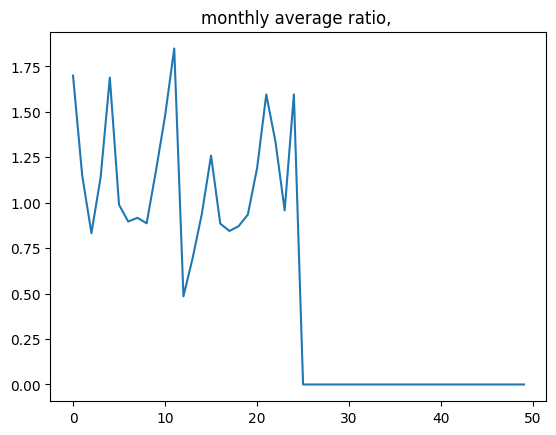

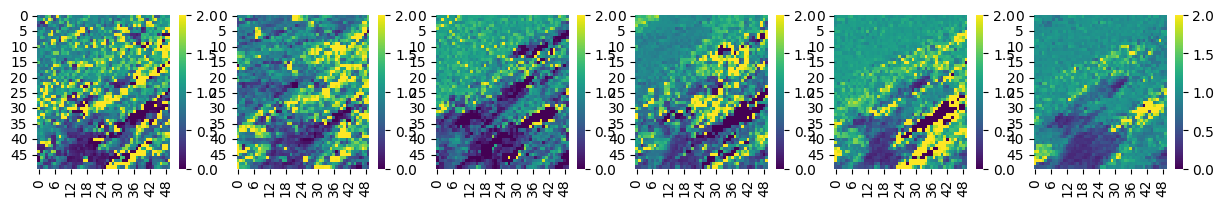

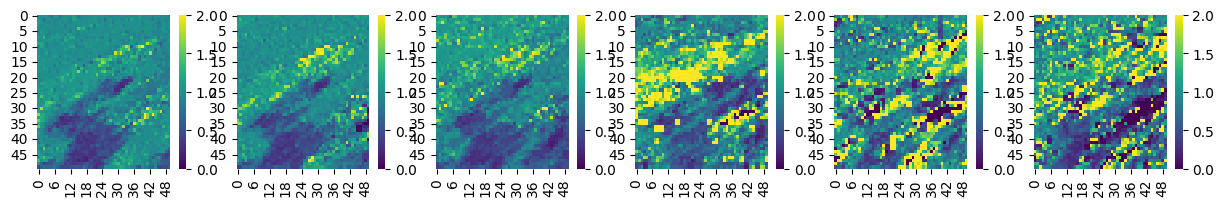

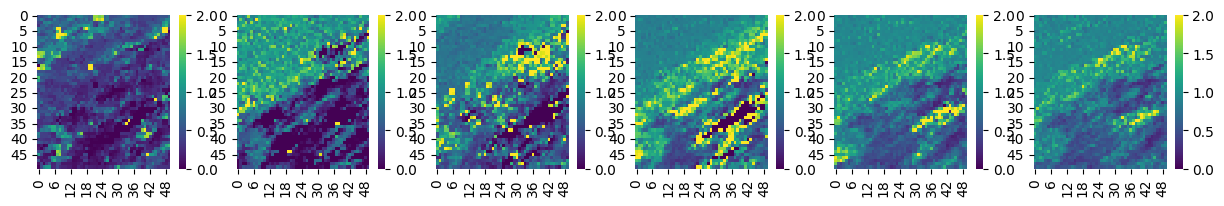

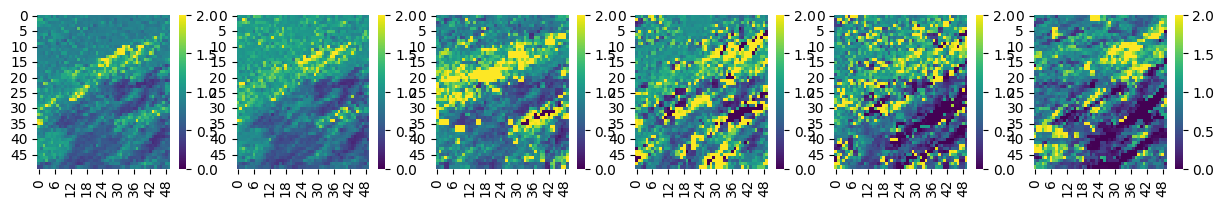

In [262]:
print(info['name'])
ndvi_r = folder + '/ratio_*.npy'
ndvi_g = glob(ndvi_r)
ndvi_g.sort()
data = np.zeros(shape=(0,  2, dims, dims ))
avg_ndvi= np.zeros((50, 1))

criterion = 0

# Count the number of occurrences that meet the criterion

for i in range(len(ndvi_g)):
    arr13 = np.load(ndvi_g[i])
    count = np.sum(arr13[0:2,:,:] == 0)  
    print(ndvi_g[i], 'zero counts ', count)
    arr13 = arr13[np.newaxis, 0:2, :,:]
    data = np.append(data, arr13, axis=0)
    avg_ndvi[i] = np.mean(arr13[:,1, :,:])

plt.plot(avg_ndvi[:])
# Adding labels and title
plt.title('monthly average ratio, ')
plt.show()

f, axes = plt.subplots(1, 6, figsize=(15, 2))
for i in range(6):
    sns.heatmap(data[i, 1, :, :],  ax=axes[i], cmap='viridis', vmin = 0, vmax =2)
plt.show()

f, axes = plt.subplots(1, 6, figsize=(15, 2))
for i in range(6,12):
    sns.heatmap(data[i, 1, :, :],  ax=axes[i-6], cmap='viridis', vmin = 0, vmax =2)
plt.show()

f, axes = plt.subplots(1, 6, figsize=(15, 2))
for i in range(12,18):
    sns.heatmap(data[i, 1, :, :],  ax=axes[i-12], cmap='viridis', vmin = 0, vmax =2)
plt.show()

f, axes = plt.subplots(1, 6, figsize=(15, 2))
for i in range(18,24):
    sns.heatmap(data[i, 1, :, :],  ax=axes[i-18], cmap='viridis', vmin = 0, vmax =2)
plt.show()

In [33]:

data = np.zeros(shape=(0,  channels, dims, dims ))
# for i in range(12, len(ndvi_g)):
for i in range(len(ndvi_g)):
    arr13 = np.load(ndvi_g[i])
    print(ndvi_g[i])
    arr13 = arr13[np.newaxis, :, :,:]
#         arr13 = np.transpose(arr13, (0, 3, 1, 2 ))
    data = np.append(data, arr13, axis=0)
         
fig, axes = plt.subplots(5, 6, figsize=(15, 15))

for i in range(6):
    for idx, ax in enumerate(axes[i]):
        print(data[idx+6*i, 1, 20, 35:45 ])
        ax.imshow(data[idx+6*i, 1, :, :], vmin=0, vmax=2)
        ax.set_title(f"Frame {idx + 1 + 6*i}")
        ax.axis("off")
plt.show()

/home/fun/wildfire_data/August_Complex_includes_Doe_Fire_2020-08-16/ratio_MOD13Q1_2021-12-03.npy


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 3

[[5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]
 ...
 [5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]]
[2. 5. 6. 7. 8. 9.]


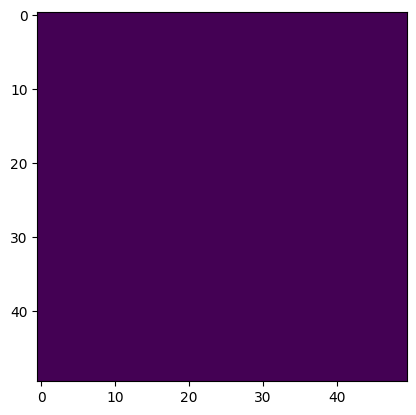

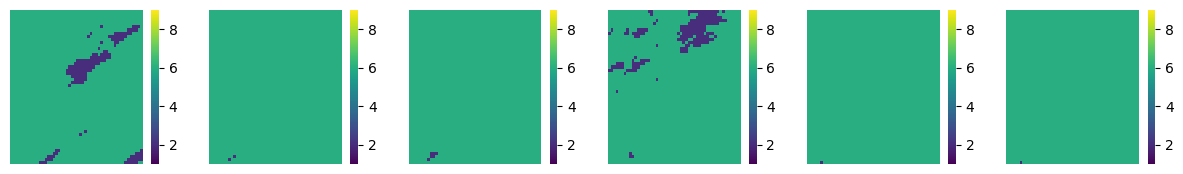

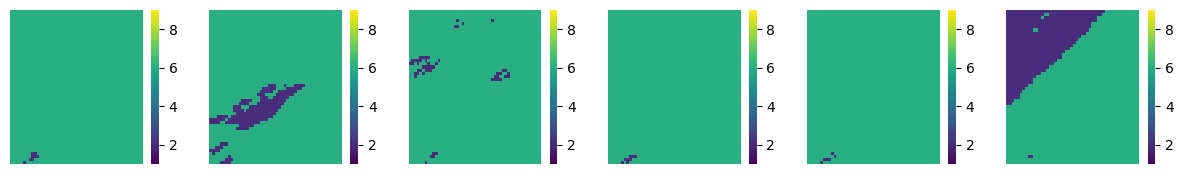

(14, 2, 50, 50)
[24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 26 26 26 26 26 26 26 26
 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27 27 27 27 27 28 28 28 28 28
 28 28 28 28 28 28 28 29 29 29 29 29 29 29 29 29 29 29 29 29 29 30 30 30
 30 30 30 30 30 30 30 30 30 30 30 30 30 30 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 33 33 33
 33 33 33 33 33 33 33 33 33 33 33 34 34 34 34 34 34 34 34 34 34 34 34 34
 34 34 34 34 34 34 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35
 35 35 35 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 37 37 37 37
 37 37 38 38 38 38 38 39 39 40 40 40 40 40 41 41 41 41 42 42 42 42 42 42
 43 43 43 43 44 44 44 45 45 45 45 46 46 47 47 47 48 48]


In [350]:
import pandas as pds
import matplotlib.pyplot as plt

dims = 50
frames = 25
channels = 2


folder = '/home/fun/wildfire_data/'+'August_Complex_includes_Doe_Fire_2020-08-16'


firemask = folder + '/MOD14*.npy'
firemask_g = glob(firemask)
firemask_g.sort()

data = np.zeros(shape=(0,  2, dims, dims ))
for i in range(len(firemask_g)):
    arr13_qa = np.load(firemask_g[i])
#     print(ndvi_g[i],arr13_qa.shape)
    arr13_qa = arr13_qa[np.newaxis, :, :,:]
    data = np.append(data, arr13_qa, axis=0)
    
layer = 0

print(data[0,layer,:,:])
print(np.unique(data))

img = plt.imshow(data[0][0])
plt.show()
    

f, axes = plt.subplots(1, 6, figsize=(15, 2))
for i in range(6):
    ax = sns.heatmap(data[i, 1, :, :],  ax=axes[i], cmap='viridis', vmin=1, vmax =9)
    ax.set_axis_off()
    
plt.show()


f, axes = plt.subplots(1, 6, figsize=(15, 2))
for i in range(6,12):
    ax =  sns.heatmap(data[i, 1, :, :],  ax=axes[i-6], cmap='viridis', vmin=1, vmax =9)
    ax.set_axis_off()
plt.show()

print(data.shape)
indices = np.where(data[7][0] == 9)
print(indices[0])
# MOD14 Fire Mask Pixel Classes
# Value	Description
# 0	Not processed (missing input data)
# 1	Not processed (obsolete; not used since Collection 1)
# 2	Not processed (other reason)
# 3	Non-fire water pixel
# 4	Cloud (land or water)
# 5	Non-fire land pixel
# 6	Unknown (land or water)
# 7	Fire (low confidence, land or water)
# 8	Fire (nominal confidence, land or water)
# 9	Fire (high confidence, land or water)

In [63]:
import geopandas as gpd
from shapely.geometry import Point

geometry = [Point(lon, lat) for lat, lon in zip(fire_locations[:,0], fire_locations[:,1])]
geo_df = gpd.GeoDataFrame(geometry=geometry)

large_fires = fire_locations[fire_locations[:, 2] > 500000] 
geometry = [Point(lon, lat) for lat, lon in zip(large_fires[:,0], large_fires[:,1])]
geo_df_large = gpd.GeoDataFrame(geometry=geometry)

i =0
fire = list()
geo_fire = list()
for year in [2013,2014,2015,2016,2017,2018,2019,2020]:
    print(i)
    fire.append( fire_locations[fire_locations[:, 3] == year]  )
    geometry = [Point(lon, lat) for lat, lon in zip(fire[i][:,0], fire[i][:,1])]
    geo_fire.append( gpd.GeoDataFrame(geometry=geometry))
    i = i+1


# Plot the GeoDataFrame
# geo_df.plot(marker='o', color='red', markersize=5)

geo_df.crs = "EPSG:4326"
print(len(geo_fire))
# Show the plot
# plt.show()

0
1
2
3
4
5
6
7
8


In [64]:
states = gpd.read_file('/home/fun/plant-predictor/map/cb_2018_us_state_500k.shp')
type(states)
states.head()
# states.crs
states[states['NAME'] == 'California']


STATEFP   STATENS     AFFGEOID GEOID STUSPS        NAME LSAD         ALAND  \
16      06  01779778  0400000US06    06     CA  California   00  403503931312   

         AWATER                                           geometry  
16  20463871877  MULTIPOLYGON (((-118.60442 33.47855, -118.5987...

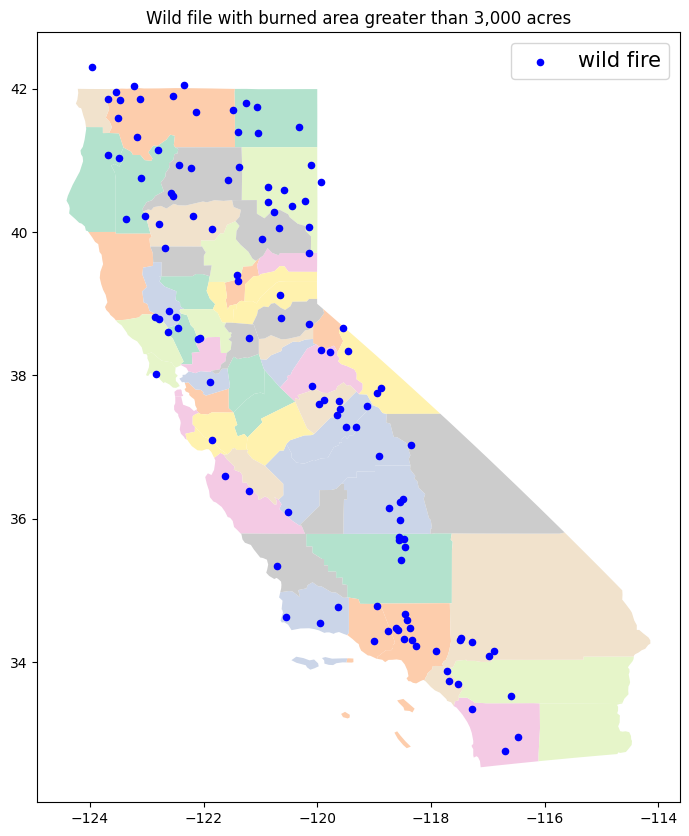

In [65]:
# counties = gpd.read_file('/home/fun/plant-predictor/map/cb_2018_us_county_500k.shp')
counties = gpd.read_file('/home/fun/plant-predictor/map/cb_2018_us_county_20m.shp')
counties.head()
# states.crs
counties[counties['STATEFP'] == '06']
# counties[counties['STATEFP'] == '06'].plot(cmap='Pastel2', figsize=(10, 10))
fig, ax = plt.subplots(figsize=(10,10))
counties[counties['STATEFP'] == '06'].plot(ax=ax, cmap='Pastel2')
geo_df.plot(ax=ax, markersize=20,  color='blue',  marker='o',  label='wild fire')

plt.title("Wild file with burned area greater than 3,000 acres")
plt.legend(prop={'size':15})
plt.show()
                                          
                            
        



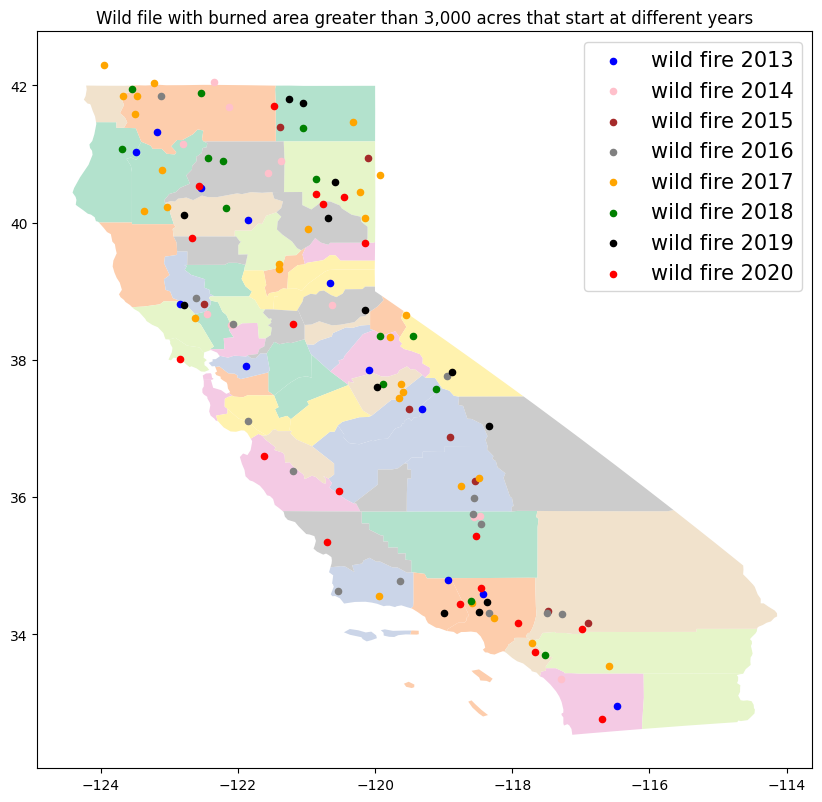

In [67]:
# counties[counties['STATEFP'] == '06'].plot(cmap='Pastel2', figsize=(10, 10))
fig, ax = plt.subplots(figsize=(10,10))
counties[counties['STATEFP'] == '06'].plot(ax=ax, cmap='Pastel2')

geo_fire[0].plot(ax=ax, markersize=20,  color='blue',  marker='o',  label='wild fire 2013')
geo_fire[1].plot(ax=ax, markersize=20,  color='pink',  marker='o',  label='wild fire 2014')
geo_fire[2].plot(ax=ax, markersize=20,  color='brown',  marker='o',  label='wild fire 2015')
geo_fire[3].plot(ax=ax, markersize=20,  color='gray',  marker='o',  label='wild fire 2016')
geo_fire[4].plot(ax=ax, markersize=20,  color='orange',  marker='o',  label='wild fire 2017')
geo_fire[5].plot(ax=ax, markersize=20,  color='green',  marker='o',  label='wild fire 2018')
geo_fire[6].plot(ax=ax, markersize=20,  color='black',  marker='o',  label='wild fire 2019')
geo_fire[7].plot(ax=ax, markersize=20,  color='red',  marker='o',  label='wild fire 2020')
plt.title("Wild file with burned area greater than 3,000 acres that start at different years")
plt.legend(prop={'size':15})
plt.show()
                  
              

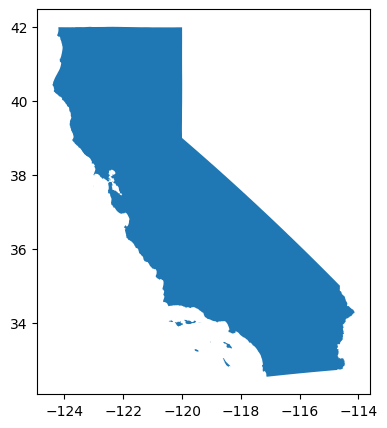

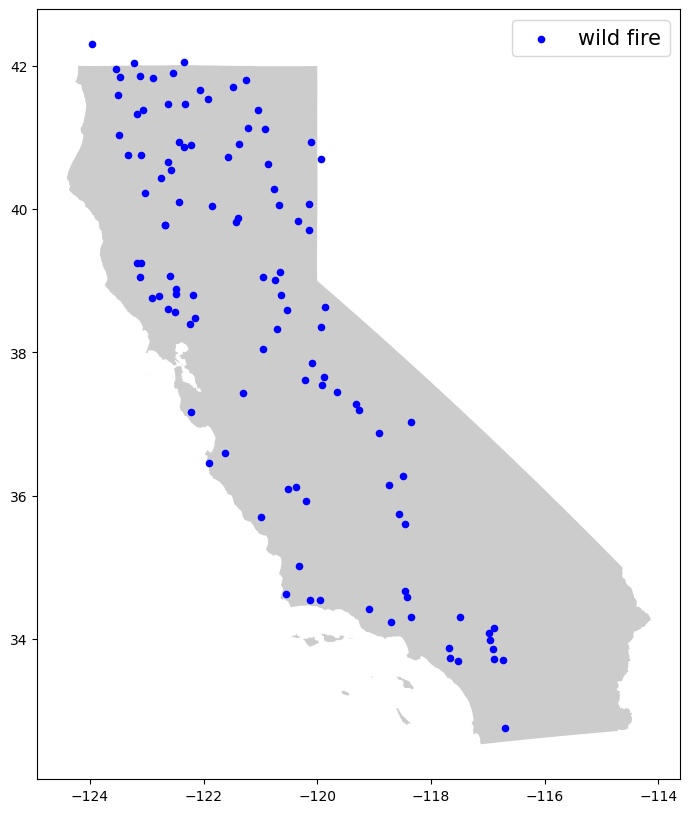

In [156]:
states = states.to_crs("EPSG:4326")
states[states['NAME'] == 'California']

states[states['NAME'] == 'California'].plot(figsize=(5, 5))


fig, ax = plt.subplots(figsize=(10,10))
states[states['NAME'] == 'California'].plot(ax=ax, alpha=0.4, color='grey')
geo_df.plot(ax=ax,
            markersize=20, 
            color='blue', 
            marker='o', 
            label='wild fire')
plt.legend(prop={'size':15})




In [291]:
import  
import numpy as np
import matplotlib.pyplot as plt



In [27]:

seeds = gpd.read_file('/home/fun/plant-predictor/map/seedMap/seedzones.shp')
seeds.head()



OBJECTID SEED_ZONE REGION SUBREGION SUBZONE     Shape_Leng    Shape_Area  \
0       1.0       091      0         9       1  202368.859869  1.346744e+09   
1       2.0       301      3         0       1  234810.252618  2.541819e+09   
2       3.0       512      5         1       2   56943.522959  1.727634e+08   
3       4.0       511      5         1       1   86465.219465  2.717440e+08   
4       5.0       321      3         2       1  176918.550894  1.569239e+09   

                                            geometry  
0  POLYGON ((-349495.009 450029.872, -348222.200 ...  
1  POLYGON ((-311350.689 448203.967, -311328.064 ...  
2  POLYGON ((-310506.209 448203.354, -310168.642 ...  
3  POLYGON ((-278260.724 447261.913, -278141.161 ...  
4  POLYGON ((-239675.194 446505.058, -239053.639 ...

<Axes: >

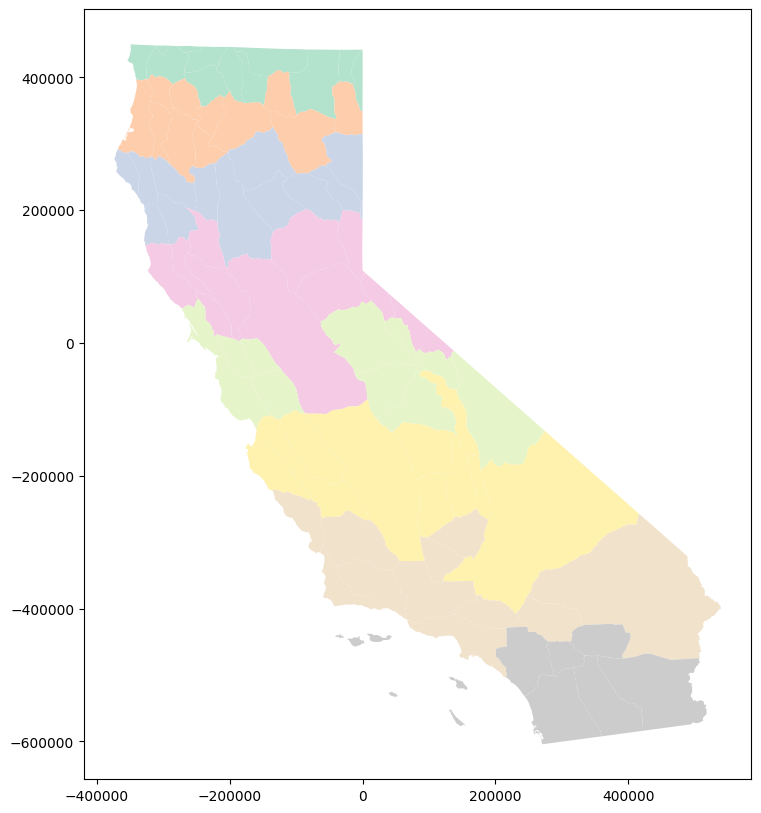

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
seeds.plot(ax=ax, cmap='Pastel2')


In [277]:
import os
import glob
# dont run while data downloading is in progress!!!
htmls = glob.glob('/home/fun/wildfire_data/July_Complex_2020-07-24/MOD*.')
for it in htmls:
    os.remove(it)

In [7]:
tensor_shape = (10, 30, 5)

# Generate random values between 0 and 1 for each element in the tensor
random_tensor = np.random.rand(*tensor_shape)
# print(random_tensor)

random_tensor[0,0,0] = None
random_tensor[1,0,2] = None
random_tensor[2,0,2] = None
random_tensor[0,23,2] = None
random_tensor[0,12,2] = None
random_tensor[4,0,1] = None
random_tensor[0,4,0] = None

# print(random_tensor )

print(random_tensor[0,0,2])
print(random_tensor[1,0,2] )
print(random_tensor[2,0,2] )
print(random_tensor[0,23,2])
print(random_tensor[0,12,2] )
print(random_tensor[4,0,1] )
print(random_tensor[0,4,0] )

import math

def euclidean_distance(point1, point2):
    squared_distance = 0
    for i in range(len(point1)):
        if point1[i] is not None and point2[i] is not None:
            squared_distance += (point1[i] - point2[i]) ** 2
    return math.sqrt(squared_distance)


def find_k_nearest_neighbors(tensor, missing_idx, k, distance_metric):
    distances = []
    for i in range(len(tensor)):
        if i == missing_idx:
            continue
        distance = distance_metric(tensor[missing_idx], tensor[i])
        distances.append((i, distance))
    distances.sort(key=lambda x: x[1])
    return [idx for idx, _ in distances[:k]]

def knn_imputation(tensor, k, distance_metric):
    filled_tensor = [row[:] for row in tensor]  # Create a copy of the tensor

    for i in range(len(tensor)):
        for j in range(len(tensor[i])):
            if tensor[i][j] is None:
                neighbors = find_k_nearest_neighbors(tensor, i, k, distance_metric)
                neighbor_values = [tensor[n][j] for n in neighbors if tensor[n][j] is not None]
                filled_tensor[i][j] = sum(neighbor_values) / len(neighbor_values)

    return filled_tensor

k = 2  # Number of nearest neighbors to consider
filled_tensor = knn_imputation(random_tensor, k, euclidean_distance)
print(len(filled_tensor))

new_tensor = np.zeros(tensor_shape)
print(new_tensor[5,0,2])
print(new_tensor[1,0,2] )
print(new_tensor[2,0,2] )
print(new_tensor[0,23,2])
print(new_tensor[0,12,2] )
print(new_tensor[4,0,1] )
print(new_tensor[0,4,0] )

for i in range(tensor_shape[0]):
    print(filled_tensor[i])
    new_tensor[i] = filled_tensor[i]
    print(new_tensor[i,0,:])

print(new_tensor.shape)

print(new_tensor[1,0,2])
print(new_tensor[1,0,2] )
print(new_tensor[2,0,2] )
print(new_tensor[0,23,2])
print(new_tensor[0,12,2] )
print(new_tensor[4,0,1] )
print(new_tensor[0,4,0] )
   



# print(filled_tensor[0,0,2])
# print(filled_tensor[1,0,2] )
# print(filled_tensor[2,0,2] )
# print(filled_tensor[0,23,2])
# print(filled_tensor[0,12,2] )
# print(filled_tensor[4,0,1] )
# print(filled_tensor[0,4,0] )



0.4402905567085821
nan
nan
nan
nan
nan
nan
10
0.0
0.0
0.0
0.0
0.0
0.0
0.0
[[       nan 0.77807228 0.44029056 0.54587593 0.48885373]
 [0.93837152 0.54811234 0.88800784 0.57296378 0.26864601]
 [0.60086791 0.36611974 0.68235576 0.31229625 0.47989877]
 [0.58713121 0.27742174 0.26617535 0.08082662 0.11158281]
 [       nan 0.74189397 0.32654363 0.47317755 0.49135917]
 [0.14584173 0.30429365 0.08841684 0.78694045 0.01416232]
 [0.98495472 0.51187509 0.56645506 0.27929097 0.98036486]
 [0.12563183 0.47402352 0.98814251 0.39772701 0.26196402]
 [0.90037428 0.9241864  0.73598717 0.3911767  0.99305925]
 [0.05416608 0.58335011 0.0039543  0.05383666 0.93286828]
 [0.49593426 0.0012366  0.11159988 0.40854684 0.28781986]
 [0.78897785 0.41996431 0.34175814 0.94328051 0.08331941]
 [0.07414239 0.19872307        nan 0.99683583 0.58440601]
 [0.00322511 0.4332894  0.1540317  0.18080061 0.4964358 ]
 [0.6514485  0.3791694  0.02886392 0.56039809 0.99560719]
 [0.1384189  0.8289985  0.1837669  0.35959526 0.59844197

In [322]:
import numpy as np

def euclidean_distance(tensor1, tensor2):
    squared_distance = np.sum((tensor1 - tensor2) ** 2)
    return np.sqrt(squared_distance)

def find_k_nearest_neighbors(tensor, missing_idx, k, distance_metric):
    distances = []
    for i in range(len(tensor)):
        if i == missing_idx:
            continue
        distance = distance_metric(tensor[missing_idx], tensor[i])
        distances.append((i, distance))
    distances.sort(key=lambda x: x[1])
    return [idx for idx, _ in distances[:k]]

def weighted_euclidean_distance(tensor1, tensor2):
    weights = [1,1,5]
    weighted_diff = (tensor1 - tensor2) * weights
    print(weighted_diff)
    squared_distance = np.sum(weighted_diff ** 2)
    return np.sqrt(squared_distance)


def knn_imputation(tensor, k, distance_metric):
    filled_tensor = np.copy(tensor)

    for i in range(tensor.shape[0]):
        for j in range(tensor.shape[1]):
            for z in range(tensor.shape[2]):
                if np.isnan(tensor[i, j, z]):
                    neighbors = find_k_nearest_neighbors(tensor, i, k, distance_metric)
                    neighbor_values = [tensor[n, j, z] for n in neighbors if not np.isnan(tensor[n, j, z])]
                    filled_tensor[i, j, z] = np.mean(neighbor_values)

    return filled_tensor

# Example random 3-dimensional tensor with missing values (np.nan)
tensor = np.random.rand(2, 3, 5)
tensor[0, 2, 4] = np.nan
tensor[1, 1, 3] = np.nan
tensor[0, 1, 2] = np.nan

k = 4  # Number of nearest neighbors to consider
filled_tensor = knn_imputation(tensor, k, weighted_euclidean_distance)
print("Original Tensor:")
print(tensor)
print("\nFilled Tensor:")
print(filled_tensor)





ValueError: operands could not be broadcast together with shapes (3,5) (3,) 

In [72]:
import umap
import numpy as np
data = np.random.rand(100, 20)  # 100 samples with 20 features each
umap_model = umap.UMAP()
umap_result = umap_model.fit_transform(data)
print("UMAP result shape:", umap_result.shape)

UMAP result shape: (100, 2)


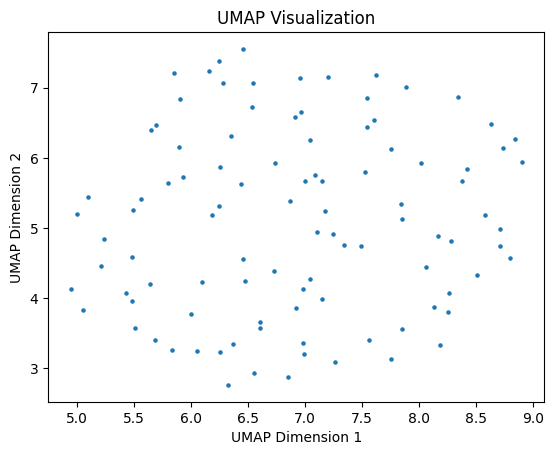

In [73]:
import matplotlib.pyplot as plt

# Plot the UMAP result
plt.scatter(umap_result[:, 0], umap_result[:, 1], s=5)
plt.title("UMAP Visualization")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

In [321]:
import pywt
import numpy as np

# Function to fill missing coefficients using linear interpolation
def interpolate_nan(coeff):
    nan_mask = np.isnan(coeff)
    coeff[nan_mask] = np.interp(np.flatnonzero(nan_mask), np.flatnonzero(~nan_mask), coeff[~nan_mask])
    return coeff

# Example 3D tensor with NaN values
your_3d_tensor = np.random.rand(5, 5, 5)
your_3d_tensor[2, 3:4, 1:2] = np.nan

# Choose a 3D wavelet for the transform (e.g., 'db1', 'haar', 'bior2.2', etc.)
wavelet = 'haar'

# Flatten the 3D tensor into a 1D array
flattened_data = your_3d_tensor.flatten()

# Find indices of NaN values in the flattened array
nan_indices = np.isnan(flattened_data)

# Perform wavelet decomposition on the non-NaN values
coeffs = pywt.wavedec(flattened_data[~nan_indices], wavelet, level=1)

# Fill missing coefficients using interpolation
coeffs_filled = [interpolate_nan(coeff) for coeff in coeffs]

# Reconstruct the 1D array with filled coefficients
flattened_data[~nan_indices] = np.concatenate(coeffs_filled)

# Reshape the 1D array back to the original 3D tensor shape
filled_tensor = flattened_data.reshape(your_3d_tensor.shape)


flattened_data = filled_tensor.flatten()
nan_indices = np.isnan(flattened_data)
coeffs = pywt.wavedec(flattened_data[~nan_indices], wavelet, level=1)
coeffs_filled = [interpolate_nan(coeff) for coeff in coeffs]
flattened_data[~nan_indices] = np.concatenate(coeffs_filled)
filled_tensor_2 = flattened_data.reshape(your_3d_tensor.shape)

print(your_3d_tensor)
print('===========')
print(filled_tensor)
print('===========')
print(filled_tensor_2)


[[[0.53586688 0.69560943 0.16088206 0.41899354 0.22162405]
  [0.02134171 0.26291769 0.20808201 0.87043375 0.7094301 ]
  [0.19182341 0.58066766 0.82232344 0.71663977 0.060851  ]
  [0.99616125 0.71308904 0.47101621 0.94940459 0.10987566]
  [0.54733691 0.89525896 0.68073559 0.99276844 0.27783965]]

 [[0.97862657 0.55435039 0.97768915 0.36248793 0.11566133]
  [0.36186447 0.13021254 0.52963586 0.42870489 0.21035112]
  [0.26115916 0.896311   0.35691765 0.58621343 0.89845717]
  [0.74784824 0.27310656 0.09379591 0.13432836 0.94129986]
  [0.54484647 0.58329541 0.34208423 0.63995074 0.68816287]]

 [[0.02255029 0.20579359 0.28557809 0.8286879  0.39596908]
  [0.98935529 0.31860735 0.48701339 0.56934331 0.12263809]
  [0.15276932 0.16841013 0.43349967 0.66428025 0.2501756 ]
  [0.0193549         nan 0.94170812 0.47154068 0.77689052]
  [0.97757898 0.42140025 0.51757989 0.87638442 0.72755318]]

 [[0.28164325 0.714016   0.9745818  0.23432478 0.98575118]
  [0.14385727 0.94580133 0.51105048 0.85392792 0.3